In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import os
import glob

# Load models

In [2]:
def downsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.Conv2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.LeakyReLU(0.2))
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

def upsample(input_channels, output_channels, kernel_size, apply_batchnorm=True, dropout_prob=0.0, weight_mean=0, weight_sd=0.02):
    layers = [nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2, padding=1, bias=False)]
    
    # Initialize the weights with mean and standard deviation
    nn.init.normal_(layers[0].weight, mean=weight_mean, std=weight_sd)
    
    if apply_batchnorm:
        layers.append(nn.BatchNorm2d(output_channels))
    layers.append(nn.ReLU())
    
    if dropout_prob > 0.0:
        layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Define the downsample layers
        self.conv_layers = nn.ModuleList([
            downsample(1, 64, 4),
            downsample(64, 128, 4),
            downsample(128, 256, 4),
            downsample(256, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4),
            downsample(512, 512, 4)
        ])

        # Define the upsample layers
        self.up_layers = nn.ModuleList([
            upsample(512, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 512, 4),
            upsample(1024, 256, 4),
            upsample(512, 128, 4),
            upsample(256, 64, 4)
        ])

        # Final convolutional layer for generating the output
        self.last = nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1)

    def forward(self, x):
        # Downsampling through the model
        skips = []
        for layer in self.conv_layers:
            x = layer(x)
            skips.append(x)
        
        skips = skips[:-1]

        # Upsampling and establishing skip connections
        for layer, skip in zip(self.up_layers, reversed(skips)):
            x = layer(x)
            x = torch.cat([x, skip], dim=1)

        x = self.last(x)
        return x



In [3]:
# Dictionary to hold lists of model instances
model_paths = {
    'unet': [],
    'unet_L2': [],
    'generator': [],
    'generator_L2': []
}

# Define the directory where your models are saved
model_dir = './saved_models'

# Pattern to match model files
patterns = {
    'unet': 'pytorch_generator_only_L1_*.pth',
    'unet_L2': 'pytorch_generator_only_L2_*.pth',
    'generator': 'pytorch_pix2pix_generator_L1_*.pth',
    'generator_L2': 'pytorch_pix2pix_generator_L2_*.pth'
}

# Load all models based on the patterns
for model_key, pattern in patterns.items():
    model_files = glob.glob(os.path.join(model_dir, pattern))
    for model_file in model_files:
        #print(f'Loading {model_key} model from {model_file}')
        #model_state = load_model_state(model_file)
        model_paths[model_key].append(model_file)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Your model loading function
def load_model_state(file_path):
    model_state = Generator()  # Assuming Generator is a defined class
    model_state.load_state_dict(torch.load(file_path))
    model_state.eval()
    model_state.to(device)
    return model_state

In [5]:
# # Instantiate the Generator model
# unet = Generator()
# generator = Generator()
# unet_L2 = Generator()
# generator_L2 = Generator()

# # Load unet
# unet.load_state_dict(torch.load('pytorch_generator_only_L1.pth'))
# unet.eval()
# unet_L2.load_state_dict(torch.load('pytorch_generator_only_L2.pth'))
# unet_L2.eval()

# # Load pix2pix
# generator.load_state_dict(torch.load('pytorch_pix2pix_generator_L1.pth'))
# generator.eval()
# generator_L2.load_state_dict(torch.load('pytorch_pix2pix_generator_L2.pth'))
# generator_L2.eval()

In [6]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# generator.to(device)
# unet.to(device)
# unet_L2.to(device)
# generator_L2.to(device)

# Load data

In [7]:
master_folder = "Physics-based data/Refined Data Set"
input_files_list = []
output_files_list = []
file_paths_list = []  # List to store file paths

# Navigate through each subfolder in the master folder
for subfolder in os.listdir(master_folder):
    subfolder_path = os.path.join(master_folder, subfolder)
    
    if os.path.isdir(subfolder_path):
        # List all input files with the naming pattern in this subfolder
        input_files = [f for f in os.listdir(subfolder_path) if "Inj_256x256_InjEnergyFactor_" in f and f.endswith(".csv")]
        output_files = [f for f in os.listdir(subfolder_path) if "UV_256x256_InjEnergyFactor_" in f and f.endswith(".csv")]

        for i in range(len(input_files)):
            input_files_list.append(os.path.join(subfolder_path, input_files[i]))
            output_files_list.append(os.path.join(subfolder_path, output_files[i]))
            file_paths_list.append(output_files[i])
            
print(f"Number of input files: {len(input_files_list)},", f"Number of output files: {len(output_files_list)}")

Number of input files: 1360, Number of output files: 1360


In [8]:
input_data = np.array([pd.read_csv(filename, header=None) for filename in input_files_list])
output_data = np.array([pd.read_csv(filename, header=None) for filename in output_files_list])

In [ ]:
# unsqueeze the data
input_data = np.expand_dims(input_data, axis=1)
output_data = np.expand_dims(output_data, axis=1)   

print(input_data.shape, output_data.shape)

(1360, 1, 256, 256) (1360, 1, 256, 256)


In [ ]:
# make dataloader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# split data into train and test
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    input_data, output_data, file_paths_list, test_size=0.2, random_state=42
)

# convert to tensor
# X_train = torch.from_numpy(X_train).float()
# y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# create dataloader
# train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 300
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
paths_test_sorted = sorted(paths_test)
with open('test_data_paths.txt', 'w') as file:
    # Iterate through the list and write each item to the file
    for item in paths_test_sorted:
        file.write(f"{item}\n")

# compare prediction visually, UNet vs pix2pix generator

In [ ]:
from torch.nn.functional import mse_loss
import matplotlib.gridspec as gridspec

In [ ]:
def generate_images(test_input, tar, prediction1, prediction2):
  plt.figure(figsize=(15, 15))
  display_list = [test_input, tar, prediction1, prediction2]
  title = ['Input Image', 'Ground Truth', 'UNet Predicted Image', 'Pix2Pix Predicted Image']
  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5, cmap='jet')
    plt.axis('off')
  plt.show()

# def generate_images_samescale(test_input, tar, prediction1, prediction2, colorscale=False):
#   '''
#   ensures the target and predicted are on the same color scale
#   '''

#   plt.figure(figsize=(15, 15))

#   display_list = [test_input, tar, prediction1, prediction2]
#   title = ['Input Image', 'Ground Truth', 'UNet Predicted Image', 'Pix2Pix Predicted Image']

#   global_min = min([np.min(img) for img in [tar]])#, prediction1, prediction2]])
#   global_max = max([np.max(img) for img in [tar]])#, prediction1, prediction2]])

#   plt.subplot(1, 4, 1)
#   plt.title(title[0])
#   plt.imshow(test_input, cmap='jet')
#   plt.axis('off')
#   plt.subplot(1, 4, 2)
#   plt.title(title[1])
#   plt.imshow(tar, cmap='jet', vmin=global_min, vmax=global_max)
#   plt.axis('off')
#   plt.subplot(1, 4, 3)
#   plt.title(title[2])
#   plt.imshow(prediction1, cmap='jet', vmin=global_min, vmax=global_max)
#   plt.axis('off')
#   plt.subplot(1, 4, 4)
#   plt.title(title[3])
#   plt.imshow(prediction2, cmap='jet', vmin=global_min, vmax=global_max)
#   plt.axis('off')  

#   plt.show()

def generate_images_samescale(images, titles, colorscale=True, cbar_title='Intensity'):
    fig = plt.figure(figsize=(16, 4))  # Adjust the figure size as needed
    gs = gridspec.GridSpec(1, len(images) + 1, width_ratios=[1]*len(images) + [0.05])

    # Global min and max for consistent color scaling (using the ground truth image as reference)
    global_min = min([np.min(img) for img in images[1]])
    global_max = max([np.max(img) for img in images[1]])

    for i, img in enumerate(images):
        ax = fig.add_subplot(gs[i])
        if i == 0:  # No scaling for the input image
            im = ax.imshow(img, cmap='jet')
        else:  # Scaled images
            im = ax.imshow(img, cmap='jet', vmin=global_min, vmax=global_max)
        ax.set_title(titles[i])
        ax.axis('off')

    if colorscale:
        cbar_ax = fig.add_subplot(gs[-1])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(cbar_title)

    plt.show()

def add_histograms(images, titles):
    # Calculate global min and max for x-axis range (excluding first image)
    global_min = min(np.min(img) for img in images[1:])
    global_max = max(np.max(img) for img in images[1:])

    # Determine the number of bins
    bins = 50

    # Find max y-axis value for scaling (excluding first image)
    max_count = 0
    for img in images[1:]:
        counts, _ = np.histogram(img.flatten(), bins=bins, range=(global_min, global_max))
        max_count = max(max_count, max(counts))

    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))

    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].hist(img.flatten(), bins=bins, range=(global_min, global_max) if i > 0 else None)
        axs[i].set_title(title)
        axs[i].set_xlabel('Pixel Value')
        axs[i].set_ylabel('Frequency')
        if i > 0:
            axs[i].set_ylim(top=max_count)

    plt.tight_layout()
    plt.show()

def calculate_contrast(image):
    # Replace this with your chosen method of calculating contrast
    # Using np.nanstd to ignore NaN values
    return np.nanstd(image)



In [ ]:
# load one model for unet and generator
unet_path = model_paths['unet'][0]
generator_path = model_paths['generator'][0]
unet = load_model_state(unet_path)
generator = load_model_state(generator_path)

In [ ]:
import re

selections = '''Run22,sub29
Run26,sub32
Run30,sub04
Run48,sub35
Run34,sub16
'''
selections = selections.splitlines()

def code_to_path(code):
    code = re.findall(r'\d+', code)
    code = [int(num) for num in code]
    return (f'Physics-based data/Refined Data Set/Run {code[0]} - BL4, s39708/Run_{code[0]}_BL4_s39708_Inj_256x256_InjEnergyFactor_{code[1]}.csv',
        f'Physics-based data/Refined Data Set/Run {code[0]} - BL4, s39708/Run_{code[0]}_BL4_s39708_UV_256x256_InjEnergyFactor_{code[1]}.csv')

path_selections = [code_to_path(code) for code in selections]

def load_data_from_one_path(path):
    data = np.array(pd.read_csv(path, header=None))
    return torch.from_numpy(data).float()

Image index: Run22,sub29
Output pixel intensity of the ground truth (sum of the pixels): 44360.5703125
Output energy of the ground truth (joules): 1481.4580053481013
Pixel intensity of UNet_L1 prediction (sum of the pixels): 45073.46875
Energy of UNet_L1 prediction (joules): 1505.2658394177397
UNet_L1 MSE: 0.00045145160402171314, MAPE: 37.109657287597656%, Contrast: 0.6453381180763245
Pixel intensity of pix2pix_Generator_L1 prediction (sum of the pixels): 44891.43359375
Energy of pix2pix_Generator_L1 prediction (joules): 1499.1866245297977
pix2pix_Generator_L1 MSE: 0.00026431839796714485, MAPE: 26.07781410217285%, Contrast: 0.6410122513771057


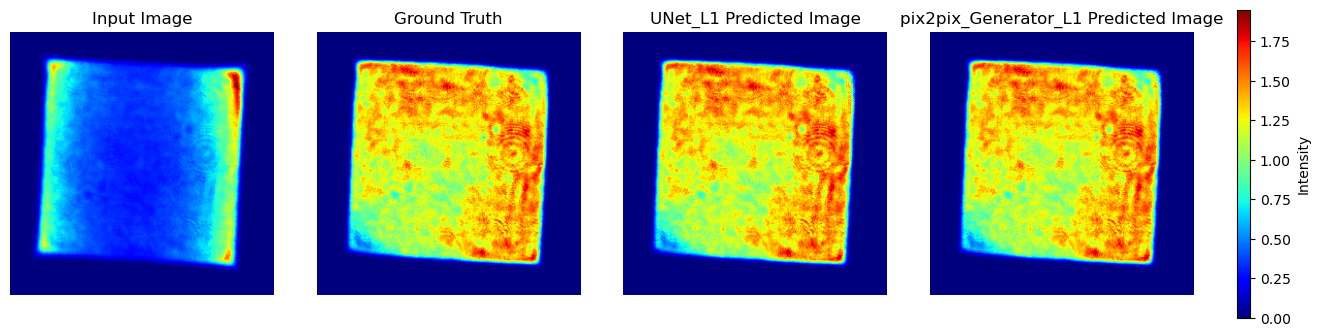

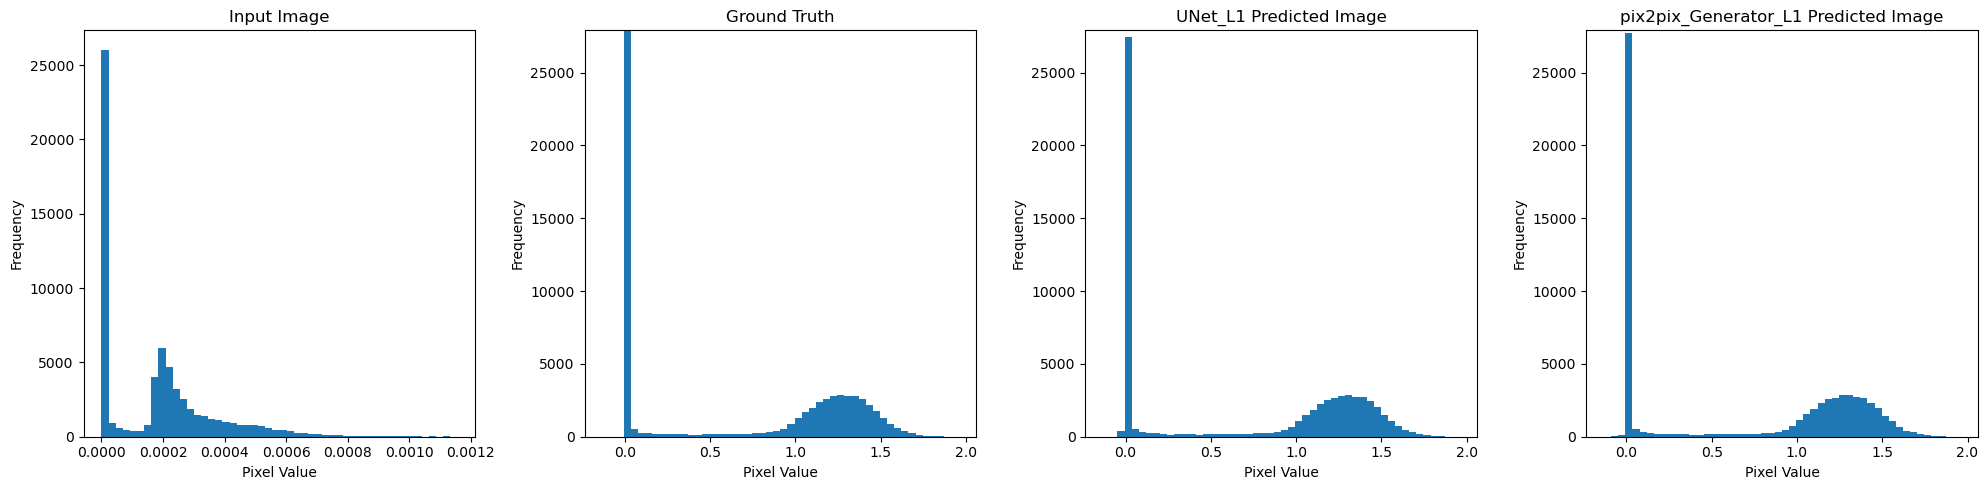

Image index: Run26,sub32
Output pixel intensity of the ground truth (sum of the pixels): 55088.15234375
Output energy of the ground truth (joules): 1839.7144967833694
Pixel intensity of UNet_L1 prediction (sum of the pixels): 56042.77734375
Energy of UNet_L1 prediction (joules): 1871.5949897164578
UNet_L1 MSE: 0.0008152914233505726, MAPE: 36.46575927734375%, Contrast: 0.8914000391960144
Pixel intensity of pix2pix_Generator_L1 prediction (sum of the pixels): 55653.75
Energy of pix2pix_Generator_L1 prediction (joules): 1858.6030992011245
pix2pix_Generator_L1 MSE: 0.0004203382704872638, MAPE: 29.25572395324707%, Contrast: 0.8832338452339172


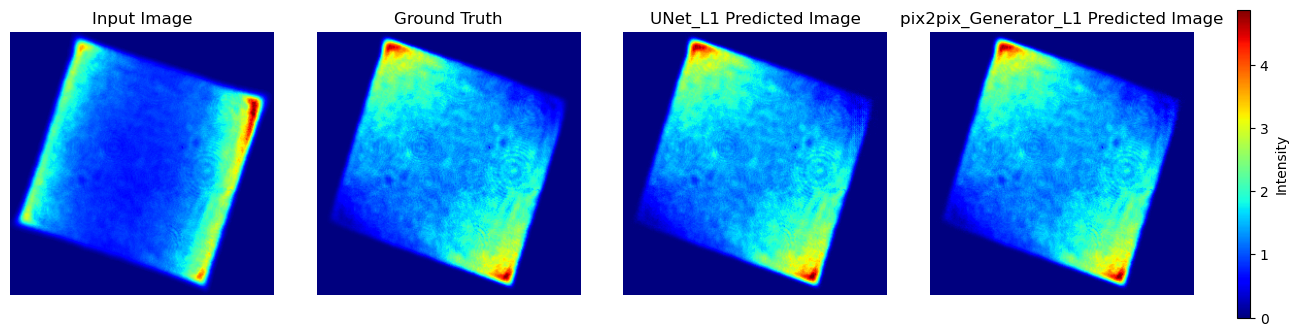

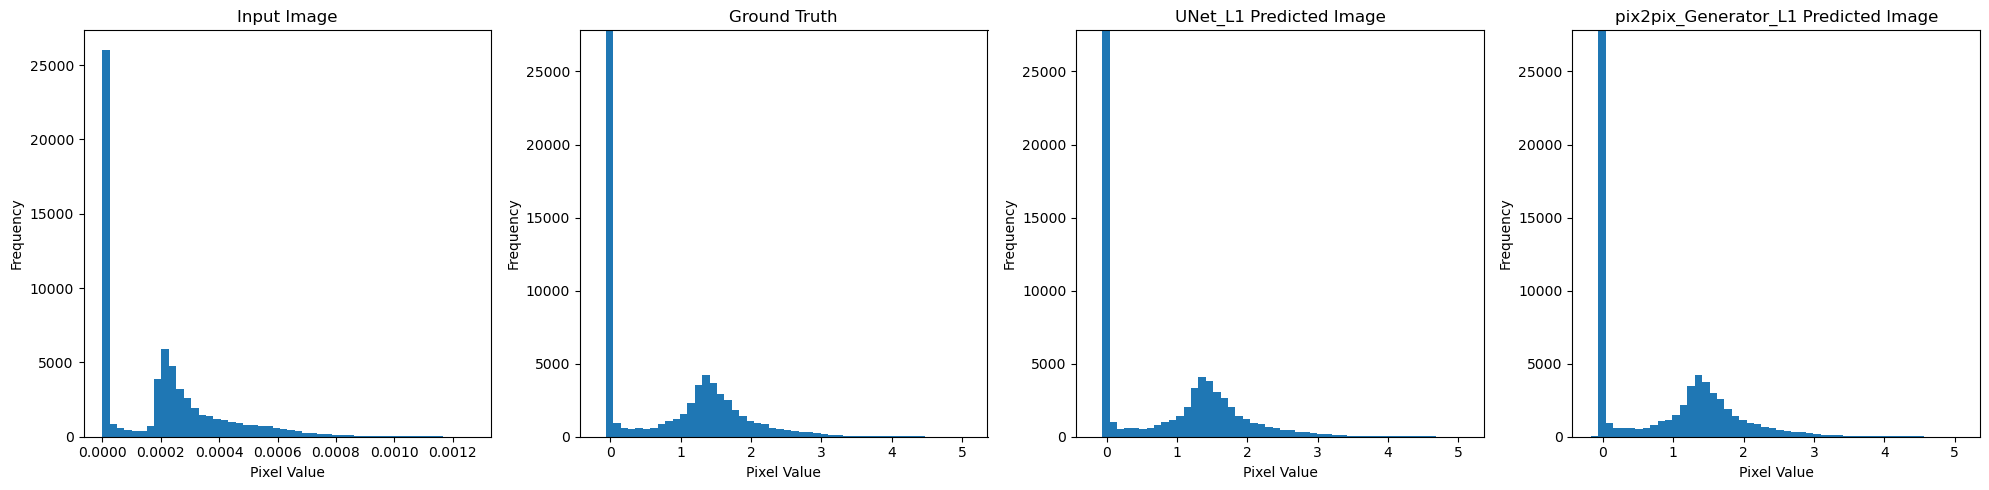

Image index: Run30,sub04
Output pixel intensity of the ground truth (sum of the pixels): 934.1747436523438
Output energy of the ground truth (joules): 31.197539676080446
Pixel intensity of UNet_L1 prediction (sum of the pixels): 848.2290649414062
Energy of UNet_L1 prediction (joules): 28.327312515914375
UNet_L1 MSE: 1.1174583050888032e-05, MAPE: 86.81360626220703%, Contrast: 0.01657673344016075
Pixel intensity of pix2pix_Generator_L1 prediction (sum of the pixels): 1112.246337890625
Energy of pix2pix_Generator_L1 prediction (joules): 37.14438812620204
pix2pix_Generator_L1 MSE: 2.0650748410844244e-05, MAPE: 71.77238464355469%, Contrast: 0.018238114193081856


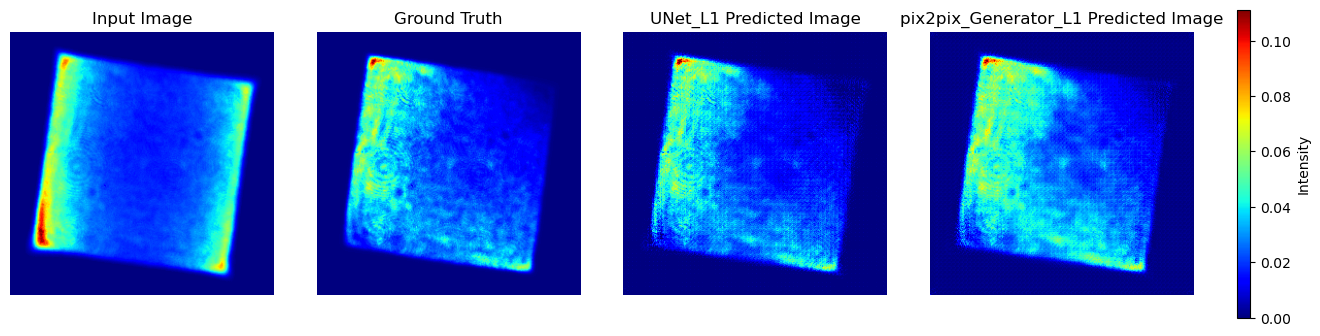

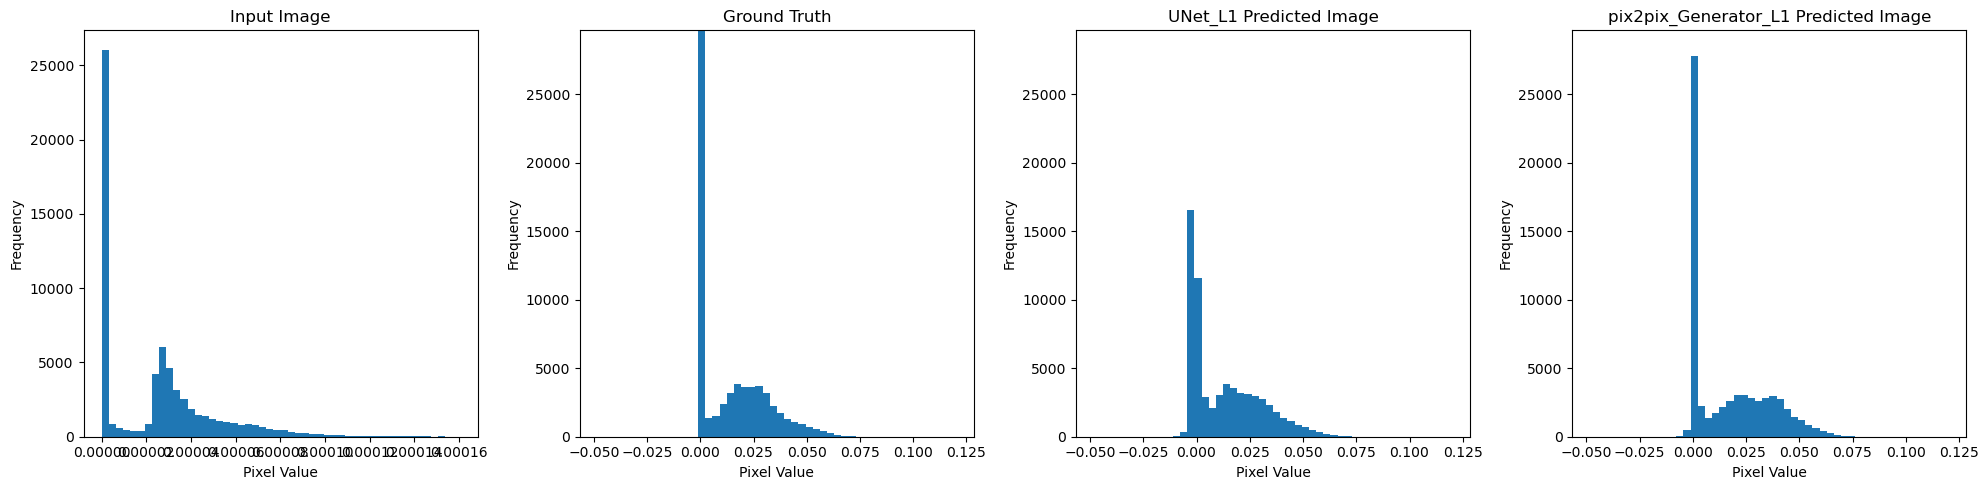

Image index: Run48,sub35
Output pixel intensity of the ground truth (sum of the pixels): 60617.70703125
Output energy of the ground truth (joules): 2024.378557684739
Pixel intensity of UNet_L1 prediction (sum of the pixels): 61590.015625
Energy of UNet_L1 prediction (joules): 2056.8496088847683
UNet_L1 MSE: 0.0014064277056604624, MAPE: 38.564292907714844%, Contrast: 0.9793181419372559
Pixel intensity of pix2pix_Generator_L1 prediction (sum of the pixels): 61286.5390625
Energy of pix2pix_Generator_L1 prediction (joules): 2046.7147576016582
pix2pix_Generator_L1 MSE: 0.0009062954923138022, MAPE: 23.14594268798828%, Contrast: 0.9716892242431641


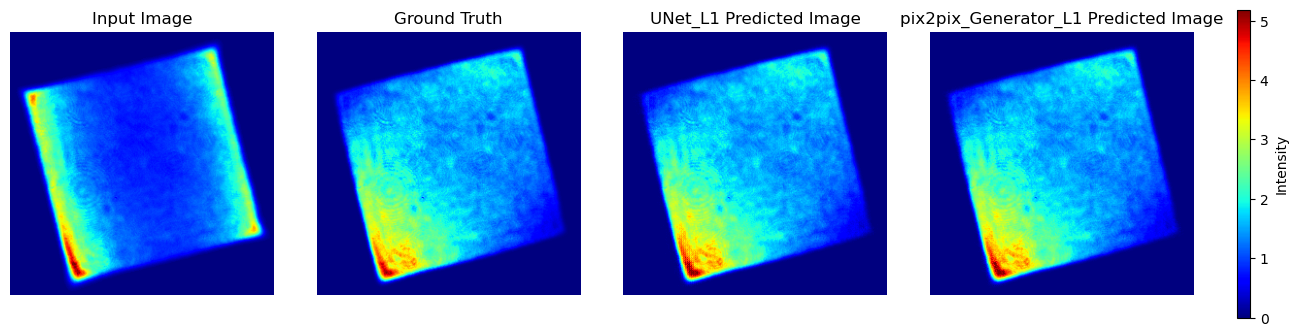

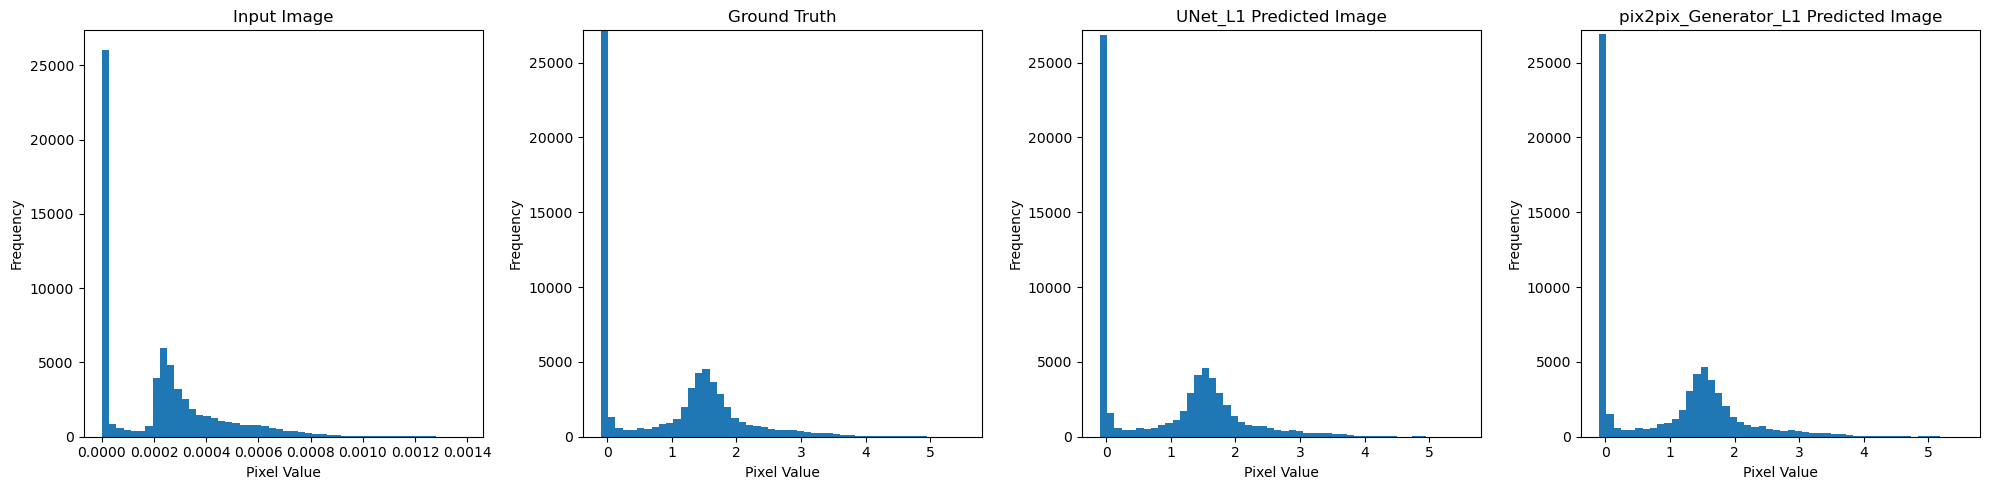

Image index: Run34,sub16
Output pixel intensity of the ground truth (sum of the pixels): 17847.9140625
Output energy of the ground truth (joules): 596.045879942283
Pixel intensity of UNet_L1 prediction (sum of the pixels): 18027.16796875
Energy of UNet_L1 prediction (joules): 602.0322126817688
UNet_L1 MSE: 0.00010017929889727384, MAPE: 31.659866333007812%, Contrast: 0.31635522842407227
Pixel intensity of pix2pix_Generator_L1 prediction (sum of the pixels): 18252.998046875
Energy of pix2pix_Generator_L1 prediction (joules): 609.5739952767594
pix2pix_Generator_L1 MSE: 0.00012267126294318587, MAPE: 25.508153915405273%, Contrast: 0.3157810568809509


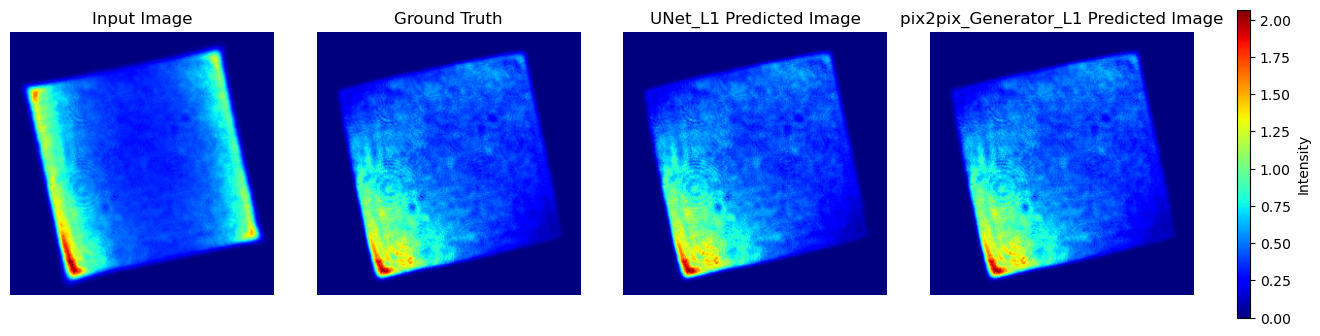

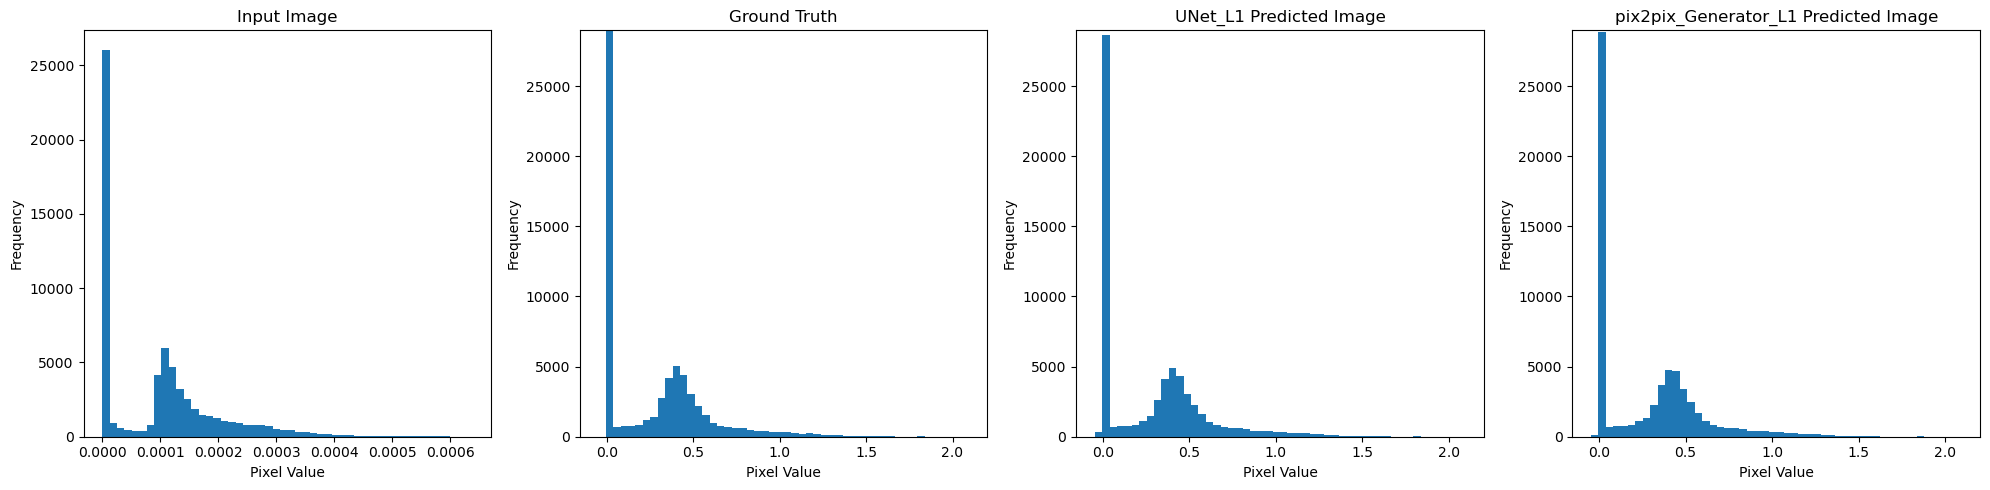

In [ ]:
models = {
    'UNet_L1': unet,
    #'UNet_L2': unet_L2,
    'pix2pix_Generator_L1': generator,
    #'Generator_L2': generator_L2
}

joules_scalar = 0.0333958286584664 # convert energy to joules

for i in range(len(path_selections)):

    input_path, output_path = path_selections[i]
    input_data = load_data_from_one_path(input_path)
    output_data = load_data_from_one_path(output_path)

    test_input_tensor = input_data.unsqueeze(0).unsqueeze(0).to(device)  # Add batch dimension
    tar_tensor = output_data.unsqueeze(0)
    
    #test_input = test_input_tensor.cpu().squeeze().numpy()  # Move input to CPU
    #tar = tar_tensor.cpu().squeeze()   # Move target to CPU

    images = [test_input_tensor, tar_tensor]
    titles = ['Input Image', 'Ground Truth']

    print(f'Image index: {selections[i]}')
    print(f'Output pixel intensity of the ground truth (sum of the pixels): {np.sum(tar_tensor.cpu().squeeze().numpy())}')
    print(f'Output energy of the ground truth (joules): {np.sum(tar_tensor.cpu().squeeze().numpy()) * joules_scalar}')

    for model_name, model in models.items():
        with torch.no_grad():
            prediction_tensor = model(test_input_tensor).cpu().squeeze()  # Generate prediction and move to CPU
            mse = mse_loss(prediction_tensor, tar_tensor.cpu().squeeze()).item()
            mape = calculate_mape(tar_tensor.cpu().squeeze(), prediction_tensor)
            
            print(f'Pixel intensity of {model_name} prediction (sum of the pixels): {np.sum(prediction_tensor.numpy())}')
            print(f'Energy of {model_name} prediction (joules): {np.sum(prediction_tensor.numpy()) * joules_scalar}')
            print(f'{model_name} MSE: {mse}, MAPE: {mape}%, Contrast: {calculate_contrast(prediction_tensor.numpy())}')

            #prediction = prediction_tensor.numpy()
            images.append(prediction_tensor)
            titles.append(f'{model_name} Predicted Image')

    images = [tensor.cpu().squeeze().numpy() for tensor in images]

    # Use the functions
    generate_images_samescale(images, titles)  # Same color scale for all images (except input)
    add_histograms(images, titles)  # Histograms for each image

# compare errors UNet vs pix2pix generator

## bootstrap and t test

In [ ]:
# from sklearn.metrics import mean_squared_error
from torch.nn.functional import mse_loss
from scipy.stats import ttest_ind
from tqdm import tqdm
import itertools

In [ ]:
'''
Bootstrapping the test data and predict
'''

# # Number of bootstrap samples
# n_bootstrap = 100
# batch_size = 64  # Set the batch size for the DataLoader

# # Models dictionary
# models = {
#     'unet': unet,
#     'unet_L2': unet_L2,
#     'generator': generator,
#     'generator_L2': generator_L2
# }

# # Initialize dictionaries to store MSEs and MAPEs for all models
# mse_lists = {model_name: [] for model_name in models}
# mape_lists = {model_name: [] for model_name in models}

# for _ in tqdm(range(n_bootstrap)):
#     # Bootstrap sampling
#     indices = np.random.choice(len(X_test), len(X_test), replace=True)
#     X_bootstrap = X_test[indices]
#     y_bootstrap = y_test[indices]

#     # Create a DataLoader for the bootstrapped data
#     bootstrap_dataset = TensorDataset(X_bootstrap, y_bootstrap)
#     bootstrap_loader = DataLoader(bootstrap_dataset, batch_size=batch_size, shuffle=False)

#     # Initialize accumulators for each model
#     mse_accumulators = {model_name: 0.0 for model_name in models}
#     mape_accumulators = {model_name: 0.0 for model_name in models}

#     for X_batch, y_batch in bootstrap_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#         # Process each model
#         for model_name, model in models.items():
#             with torch.no_grad():
#                 pred_batch = model(X_batch)
#                 mse_accumulators[model_name] += mse_loss(pred_batch, y_batch).item() * X_batch.size(0)
#                 mape_accumulators[model_name] += calculate_mape(y_batch, pred_batch) * X_batch.size(0)

#     # Calculate averages for each model
#     for model_name in models:
#         mse_lists[model_name].append(mse_accumulators[model_name] / len(X_bootstrap))
#         mape_lists[model_name].append(mape_accumulators[model_name] / len(X_bootstrap))

# # # Perform t-tests and print results
# # for model_name in models:
# #     if model_name == 'unet':  # Skip comparison with itself
# #         continue
# #     t_stat_mse, p_val_mse = ttest_ind(mse_lists['unet'], mse_lists[model_name])
# #     t_stat_mape, p_val_mape = ttest_ind(mape_lists['unet'], mape_lists[model_name])

# #     print(f"Mean MSE for {model_name}: {np.mean(mse_lists[model_name]):.4f}")
# #     print(f"MSE p-value against unet: {p_val_mse}")

# #     print(f"Mean MAPE for {model_name}: {np.mean(mape_lists[model_name]):.4f}%")
# #     print(f"MAPE p-value against unet: {p_val_mape}")

'\nBootstrapping the test data and predict\n'

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to load a model's state dictionary
def load_model_state(file_path):
    model_state = Generator()
    model_state.load_state_dict(torch.load(file_path))
    model_state.eval()
    model_state.to(device)
    return model_state

#######################################################
def calculate_mse_per_image(y_true_batch, y_pred_batch):
    # Calculate element-wise squared error with no reduction
    squared_errors = mse_loss(y_pred_batch, y_true_batch, reduction='none')

    # Compute the mean of the squared errors for each image
    # This averages over the channel, height, and width dimensions
    mse_per_image = squared_errors.mean(dim=[1, 2, 3])

    return mse_per_image

#######################################################
def calculate_mape(y_true, y_pred):
    # Avoid division by zero
    non_zero_mask = y_true != 0
    return torch.mean((torch.abs(y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) * 100).item()

def calculate_mape_per_image(y_true_batch, y_pred_batch):
    batch_size = y_true_batch.shape[0]
    mape_values = []

    for i in range(batch_size):
        # Apply calculate_mape to each image
        mape = calculate_mape(y_true_batch[i], y_pred_batch[i])
        mape_values.append(mape)

    return np.array(mape_values)

#######################################################
def calculate_UV_perc_error(y_true, y_pred):
    pred_sum = y_pred.sum()
    ground_truth_sum = y_true.sum()
    return (pred_sum - ground_truth_sum) / ground_truth_sum * 100

def calculate_UV_perc_error_per_image(y_true_batch, y_pred_batch):
    batch_size = y_true_batch.shape[0]
    perc_errors = []

    for i in range(batch_size):
        # Apply calculate_UV_perc_error to each image
        perc_error = calculate_UV_perc_error(y_true_batch[i], y_pred_batch[i])
        perc_errors.append(perc_error.item())

    return np.array(perc_errors)

#######################################################
def evaluate_model(model, dataset_loader):
    mse_accumulator = 0.0
    mape_accumulator = 0.0
    mse_norm_accumulator = 0.0
    UV_perc_error_accumulator = 0.0
    total_samples = 0

    joules_scalar = 0.0333958286584664  # Conversion factor to joules

    with torch.no_grad():
        for X_batch, y_batch in dataset_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred_batch = model(X_batch)

            # Calculate MSE and accumulate
            mse_per_image = calculate_mse_per_image(y_batch, pred_batch)
            mse_accumulator += mse_per_image.sum().item()

            # Calculate MAPE and accumulate
            mape_per_image = calculate_mape_per_image(y_batch, pred_batch)
            mape_accumulator += mape_per_image.sum().item()

            # Normalize MSE by sum of pixel values in y_batch
            sum_y_batch = torch.sum(y_batch, dim=[1, 2, 3]) * joules_scalar
            mse_norm = mse_per_image / sum_y_batch
            mse_norm_accumulator += mse_norm.sum().item()

            # Calculate UV percentage error and accumulate
            UV_perc_error_per_image = calculate_UV_perc_error_per_image(y_batch, pred_batch)
            UV_perc_error_accumulator += UV_perc_error_per_image.sum().item()

            total_samples += X_batch.size(0)

    # Calculate average MSE, MAPE, and normalized MSE
    avg_mse = mse_accumulator / total_samples
    avg_mape = mape_accumulator / total_samples
    avg_mse_norm = mse_norm_accumulator / total_samples
    avg_UV_perc_error = UV_perc_error_accumulator / total_samples

    return avg_mse, avg_mape, avg_mse_norm, avg_UV_perc_error

# Define a function for bootstrapping
def perform_bootstrap_evaluation(model, X_data, y_data, n_bootstraps, batch_size):
    mse_accumulator = 0.0
    mape_accumulator = 0.0
    mse_norm_accumulator = 0.0
    UV_perc_error_accumulator = 0.0

    for _ in range(n_bootstraps):
        # Bootstrap sampling
        indices = np.random.choice(len(X_data), len(X_data), replace=True)
        X_bootstrap = X_data[indices]
        y_bootstrap = y_data[indices]

        # Create a DataLoader for the bootstrapped data
        bootstrap_loader = DataLoader(TensorDataset(X_bootstrap, y_bootstrap),
                                      batch_size=batch_size, shuffle=False)

        # Evaluate model on this bootstrap sample
        mse, mape, mse_norm, UV_perc_error = evaluate_model(model, bootstrap_loader)
        mse_accumulator += mse
        mape_accumulator += mape
        mse_norm_accumulator += mse_norm
        UV_perc_error_accumulator += UV_perc_error

    # Calculate average MSE and MAPE
    avg_mse = mse_accumulator / n_bootstraps
    avg_mape = mape_accumulator / n_bootstraps
    avg_mse_norm = mse_norm_accumulator / n_bootstraps
    avg_UV_perc_error = UV_perc_error_accumulator / n_bootstraps

    return avg_mse, avg_mape, avg_mse_norm, avg_UV_perc_error

In [110]:
'''
Get MSE and MAPE scores
'''
n_bootstrap = 20
batch_size = 64

# Initialize dictionary to store MSEs and MAPEs for all models
performance = {model_type: {'mse': [], 'mape': [], 'mse_norm': [], 'UV_perc_error': []} for model_type in model_paths}

# Load models, perform bootstrap inference, and store performance metrics
for model_type, paths in model_paths.items():
    for model_path in tqdm(paths):
        # Load model
        model = load_model_state(model_path)  # Replace with your actual model loading function

        # Perform bootstrap evaluations
        avg_mse, avg_mape, avg_mse_norm, avg_UV_perc_error = perform_bootstrap_evaluation(model, X_test, y_test, n_bootstrap, batch_size)

        # Store average performance metrics for this model
        performance[model_type]['mse'].append(avg_mse)
        performance[model_type]['mape'].append(avg_mape)
        performance[model_type]['mse_norm'].append(avg_mse_norm)
        performance[model_type]['UV_perc_error'].append(avg_UV_perc_error)

# Now, 'performance' contains lists of averaged MSE and MAPE for each model within each model type

# Example of how you might print out the results
for model_type, metrics in performance.items():
    print(f"{model_type} - Averages over models")
    print(f"MSEs: {np.mean(metrics['mse'])}")
    print(f"MAPEs: {np.mean(metrics['mape'])}")
    print(f"MSEs (normalized): {np.mean(metrics['mse_norm'])}")
    print(f"UV Percentage Errors: {np.mean(metrics['UV_perc_error'])}")

100%|██████████| 25/25 [04:03<00:00,  9.75s/it]

unet - Averages over models
MSEs: 0.0005713295970036759
MAPEs: 53.99021160244942
MSEs (normalized): 6.782132097786122e-07
UV Percentage Errors: 3.455574374055806
unet_L2 - Averages over models
MSEs: 0.0004977967805033961
MAPEs: 129.82891423915416
MSEs (normalized): 1.1906347749623046e-06
UV Percentage Errors: -3.9023719383976925
generator - Averages over models
MSEs: 0.0006059463673274662
MAPEs: 50.416623941211135
MSEs (normalized): 6.801985652955142e-07
UV Percentage Errors: 0.2095199689135056
generator_L2 - Averages over models
MSEs: 0.0009408524536274319
MAPEs: 133.37774298780104
MSEs (normalized): 1.7171091017406955e-06
UV Percentage Errors: 5.083950424252128


In [111]:
'''
t tests and bar plots
'''

# Calculate mean MSE and MAPE for each model
mean_mse = {model_type: np.mean(perf['mse']) for model_type, perf in performance.items()}
mean_mape = {model_type: np.mean(perf['mape']) for model_type, perf in performance.items()}
mean_mse_norm = {model_type: np.mean(perf['mse_norm']) for model_type, perf in performance.items()}
mean_UV_perc_error = {model_type: np.mean(perf['UV_perc_error']) for model_type, perf in performance.items()}

# Perform t-tests and store p-values
p_values_mse = {}
p_values_mape = {}
p_values_mse_norm = {}
p_values_UV_perc_error = {}
for model_name1, model_name2 in itertools.combinations(performance.keys(), 2):
    _, p_val_mse = ttest_ind(performance[model_name1]['mse'], performance[model_name2]['mse'])
    _, p_val_mape = ttest_ind(performance[model_name1]['mape'], performance[model_name2]['mape'])
    _, p_val_mse_norm = ttest_ind(performance[model_name1]['mse_norm'], performance[model_name2]['mse_norm'])
    _, p_val_UV_perc_error = ttest_ind(performance[model_name1]['UV_perc_error'], performance[model_name2]['UV_perc_error'])
    p_values_mse[f"{model_name1} vs {model_name2}"] = p_val_mse
    p_values_mape[f"{model_name1} vs {model_name2}"] = p_val_mape
    p_values_mse_norm[f"{model_name1} vs {model_name2}"] = p_val_mse_norm
    p_values_UV_perc_error[f"{model_name1} vs {model_name2}"] = p_val_UV_perc_error

# Print p-values for reference
print("MSE p-values:")
for comparison, p_val in p_values_mse.items():
    print(f"{comparison}: {p_val}")

print("\nMAPE p-values:")
for comparison, p_val in p_values_mape.items():
    print(f"{comparison}: {p_val}")

print("\nMSE (normalized) p-values:")
for comparison, p_val in p_values_mse_norm.items():
    print(f"{comparison}: {p_val}")

print("\nUV Percentage Error p-values:")
for comparison, p_val in p_values_UV_perc_error.items():
    print(f"{comparison}: {p_val}")


MSE p-values:
unet vs unet_L2: 0.4825838017897971
unet vs generator: 0.7943522953506092
unet vs generator_L2: 0.08488557730748925
unet_L2 vs generator: 0.3977220055632441
unet_L2 vs generator_L2: 0.03719102507829473
generator vs generator_L2: 0.13832698121472659

MAPE p-values:
unet vs unet_L2: 8.411696324675397e-24
unet vs generator: 0.23723569264666716
unet vs generator_L2: 2.593396421471201e-22
unet_L2 vs generator: 6.10344351742104e-26
unet_L2 vs generator_L2: 0.49124495677302804
generator vs generator_L2: 4.4968532044646384e-24

MSE (normalized) p-values:
unet vs unet_L2: 0.013703720200455882
unet vs generator: 0.9907693587552887
unet vs generator_L2: 0.0004433532087653384
unet_L2 vs generator: 0.0032099068067961154
unet_L2 vs generator_L2: 0.05842390730730745
generator vs generator_L2: 0.00014043786341379932

UV Percentage Error p-values:
unet vs unet_L2: 0.021599888280559823
unet vs generator: 0.2517642090829517
unet vs generator_L2: 0.706088812409826
unet_L2 vs generator: 0.162

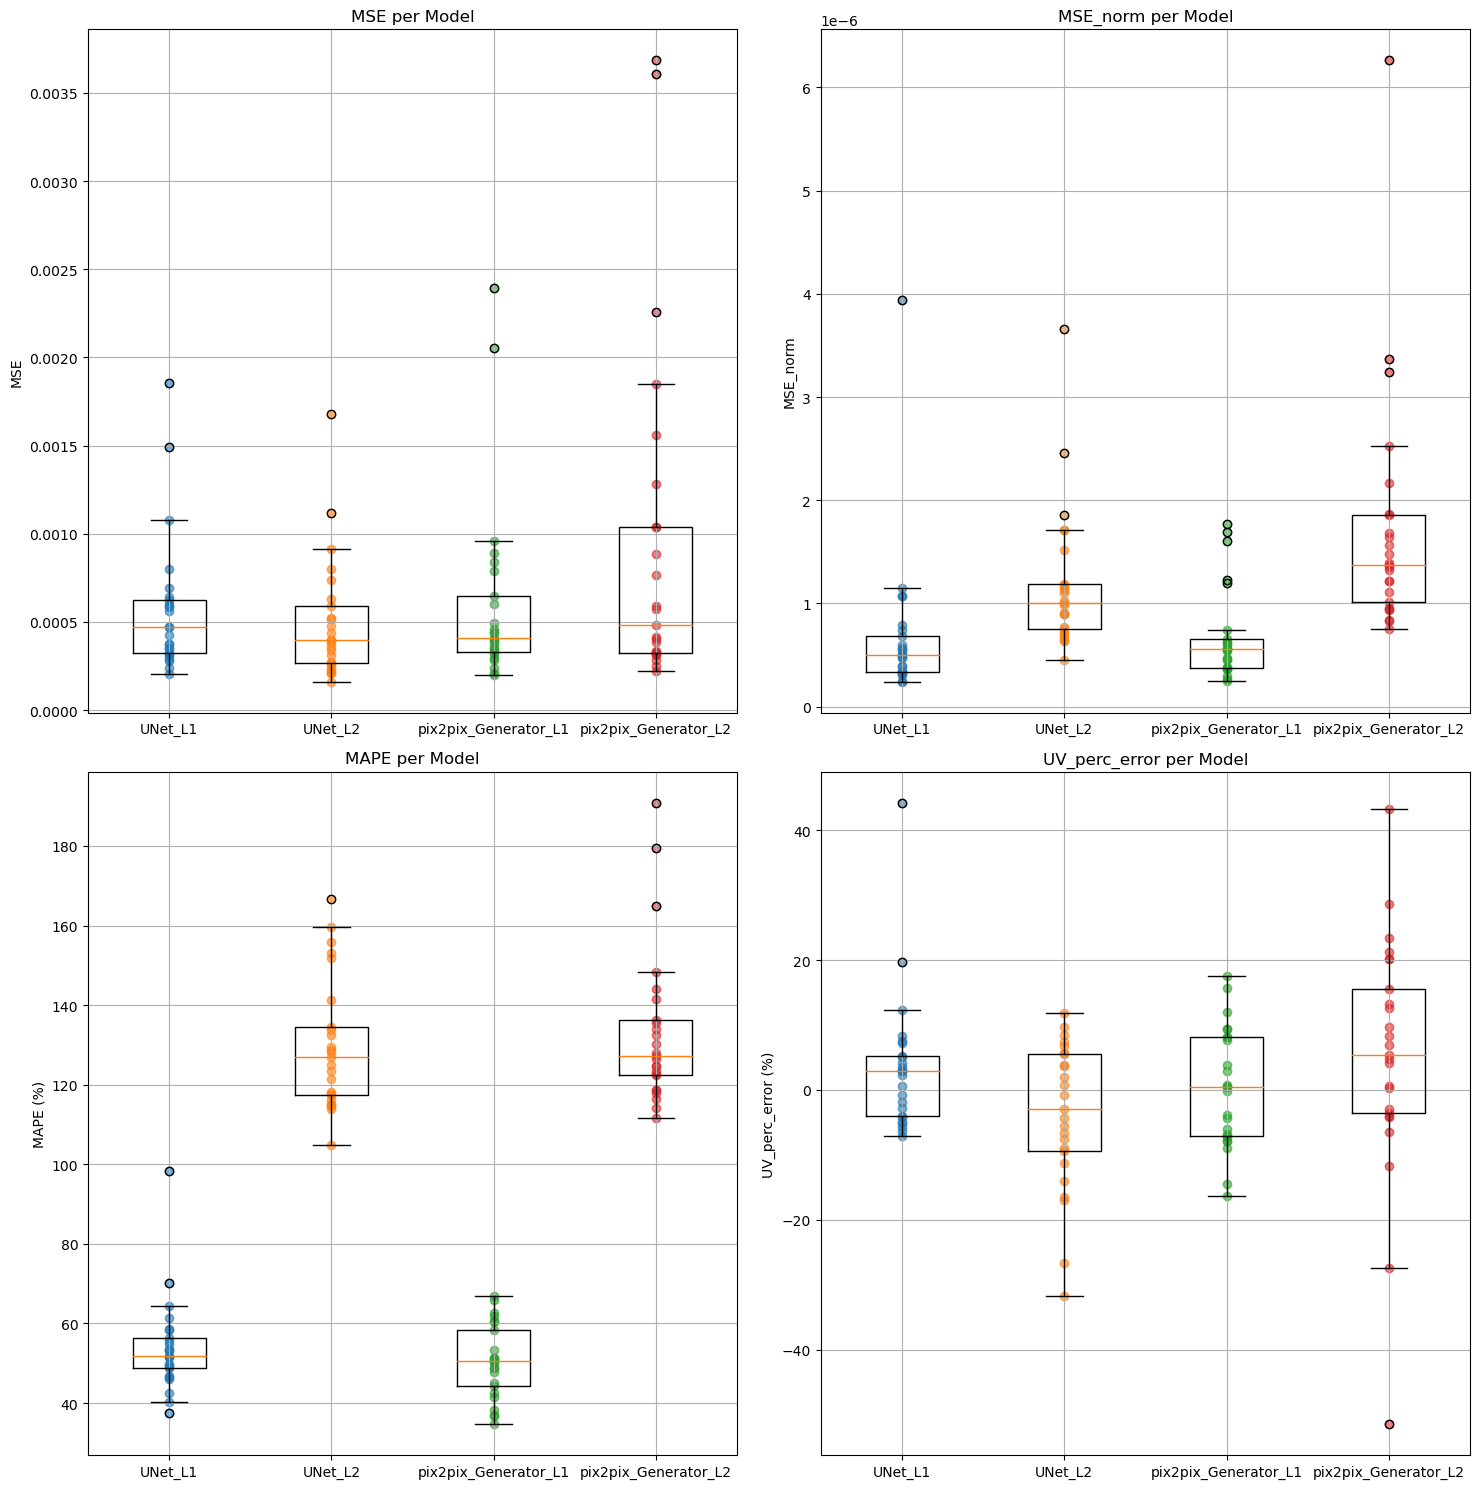

In [112]:
'''
bar plots
'''

# Prepare data for boxplots
mse_data = [performance[model_type]['mse'] for model_type in performance]
mse_norm_data = [performance[model_type]['mse_norm'] for model_type in performance]
mape_data = [performance[model_type]['mape'] for model_type in performance]
UV_perc_error_data = [performance[model_type]['UV_perc_error'] for model_type in performance]
labels = ['UNet_L1', 'UNet_L2', 'pix2pix_Generator_L1', 'pix2pix_Generator_L2'] #list(performance.keys())

# Creating boxplots
fig, axs = plt.subplots(2,2, figsize=(15, 15))

# MSE Boxplot
axs[0, 0].boxplot(mse_data, labels=labels)
for i, model_data in enumerate(mse_data, 1):
    axs[0, 0].scatter([i] * len(model_data), model_data, alpha=0.6)
axs[0, 0].set_title('MSE per Model')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].grid(True)

# MSE_norm Boxplot
axs[0, 1].boxplot(mse_norm_data, labels=labels)
for i, model_data in enumerate(mse_norm_data, 1):
    axs[0, 1].scatter([i] * len(model_data), model_data, alpha=0.6)
axs[0, 1].set_title('MSE_norm per Model')
axs[0, 1].set_ylabel('MSE_norm')
axs[0, 1].grid(True)

# MAPE Boxplot
axs[1, 0].boxplot(mape_data, labels=labels)
for i, model_data in enumerate(mape_data, 1):
    axs[1, 0].scatter([i] * len(model_data), model_data, alpha=0.6)
axs[1, 0].set_title('MAPE per Model')
axs[1, 0].set_ylabel('MAPE (%)')
axs[1, 0].grid(True)

# UV_perc_error Boxplot
axs[1, 1].boxplot(UV_perc_error_data, labels=labels)
for i, model_data in enumerate(UV_perc_error_data, 1):
    axs[1, 1].scatter([i] * len(model_data), model_data, alpha=0.6)
axs[1, 1].set_title('UV_perc_error per Model')
axs[1, 1].set_ylabel('UV_perc_error (%)')
axs[1, 1].grid(True)

# Display the boxplots
plt.tight_layout()
plt.show()

In [ ]:
# Define the number of bins and the range for the histograms
bin_width = 0.00001  # For example, 0.5
bins = np.arange(min(min(mse_lists['unet']), min(mse_lists['generator'])), max(max(mse_lists['unet']), max(mse_lists['generator'])) + bin_width, bin_width)

plt.hist(mse_lists['unet'], bins=bins, alpha=0.5, label='UNet')
plt.hist(mse_lists['generator'], bins=bins, alpha=0.5, label='pix2pix Generator')
plt.legend(loc='upper right')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Histogram of MSEs')
plt.show()

In [ ]:
# Define the number of bins and the range for the histograms
# Adjust the bin_width and range based on the MAPE values
bin_width = 1  # Adjust this based on the scale of your MAPE values
bins = np.arange(
    min(min(mape_lists['unet']), min(mape_lists['generator'])),
    max(max(mape_lists['unet']), max(mape_lists['generator'])) + bin_width,
    bin_width
)

plt.hist(mape_lists['unet'], bins=bins, alpha=0.5, label='UNet')
plt.hist(mape_lists['generator'], bins=bins, alpha=0.5, label='pix2pix Generator')
plt.legend(loc='upper right')
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')
plt.title('Histogram of MAPEs')
plt.show()

In [ ]:
# error_distribution_dict = {'UNet MSE': mse_list_unet, 
#                            'pix2pix Generator MSE': mse_list_generator,
#                            'UNet MAPE': mape_list_unet,
#                            'pix2pix Generator MAPE': mape_list_generator}

# error_distribution_df = pd.DataFrame(error_distribution_dict)

# error_distribution_df.to_csv('figure1_error_distribution.csv', index=False)

# error_distribution_df.head()

## inspect error spatial distribution

In [ ]:
def calculate_mape_pixel(y_true, y_pred):
    # # Avoid division by zero
    # non_zero_mask = y_true != 0
    return torch.abs(y_true - y_pred) / y_true * 100

def calculate_mpe_pixel(y_true, y_pred):
    # # Avoid division by zero
    # non_zero_mask = y_true != 0
    return (y_true - y_pred) / y_true * 100

def calculate_mse_pixel(y_true, y_pred):
    return torch.pow(y_true - y_pred, 2)

In [ ]:
# load one model for unet and generator
unet_path = model_paths['unet'][0]
generator_path = model_paths['generator'][0]
unet = load_model_state(unet_path)
generator = load_model_state(generator_path)

In [ ]:
import re

selections = '''Run22,sub29
Run30,sub04
'''
selections = selections.splitlines()

def code_to_path(code):
    code = re.findall(r'\d+', code)
    code = [int(num) for num in code]
    return (f'Physics-based data/Refined Data Set/Run {code[0]} - BL4, s39708/Run_{code[0]}_BL4_s39708_Inj_256x256_InjEnergyFactor_{code[1]}.csv',
        f'Physics-based data/Refined Data Set/Run {code[0]} - BL4, s39708/Run_{code[0]}_BL4_s39708_UV_256x256_InjEnergyFactor_{code[1]}.csv')

path_selections = [code_to_path(code) for code in selections]

Image index: Run22,sub29
Output pixel intensity of the ground truth (sum of the pixels): 44360.5703125
Output energy of the ground truth (joules): 1481.4580053481013
UNet MSE: 0.0004514516331255436, MAPE: 37.109657287597656%, Contrast: 0.6453381180763245
Generator MSE: 0.0002643183688633144, MAPE: 26.07781410217285%, Contrast: 0.6410122513771057


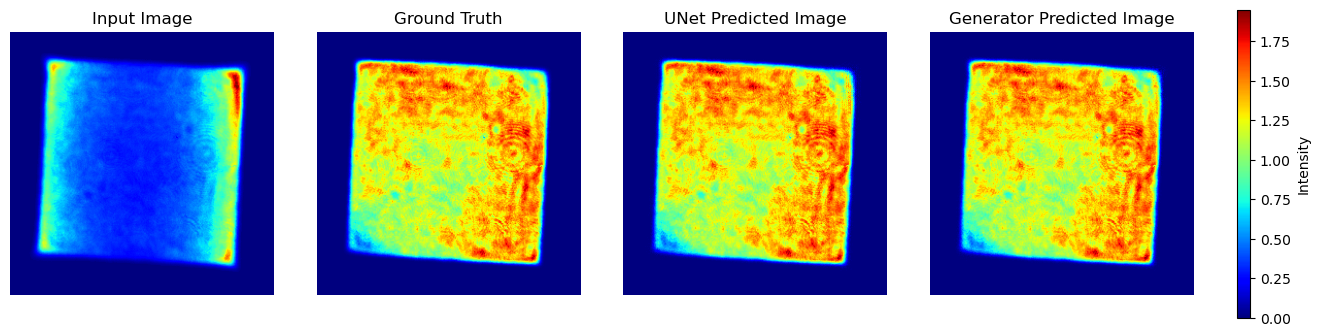

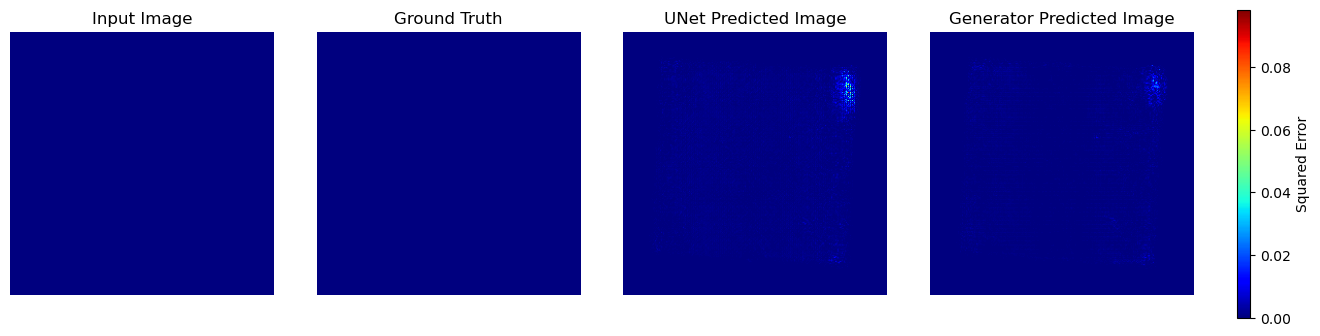

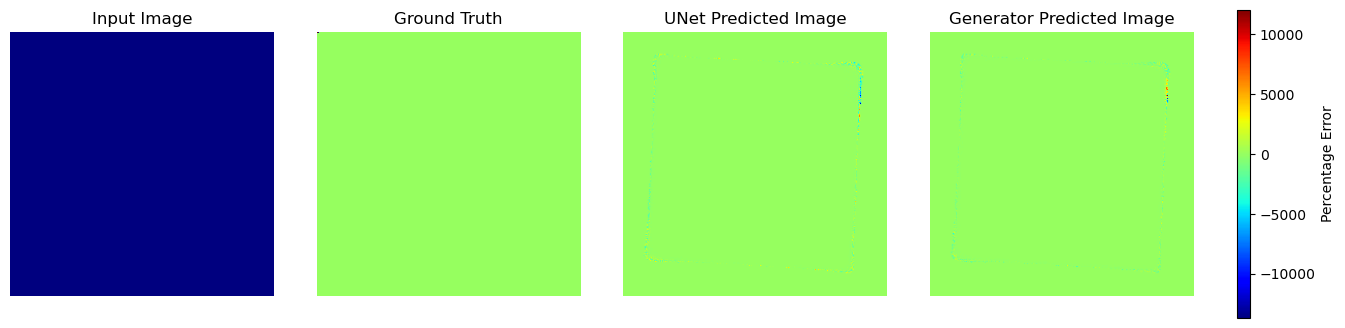

Image index: Run26,sub32
Output pixel intensity of the ground truth (sum of the pixels): 55088.15234375
Output energy of the ground truth (joules): 1839.7144967833694
UNet MSE: 0.0008152914815582335, MAPE: 36.46575927734375%, Contrast: 0.8914000391960144
Generator MSE: 0.00042033824138343334, MAPE: 29.25572395324707%, Contrast: 0.8832338452339172


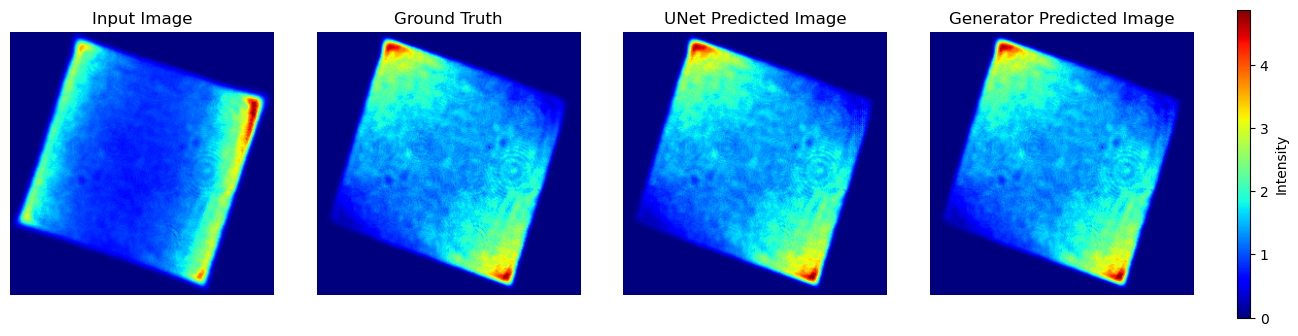

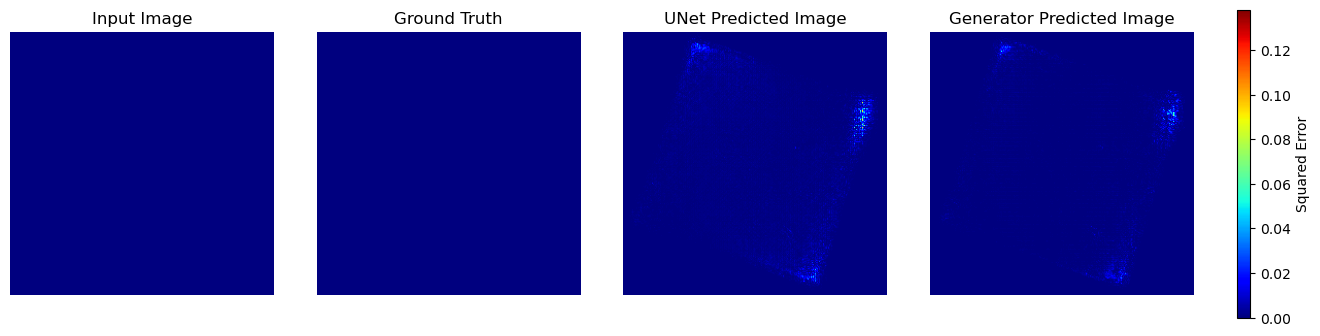

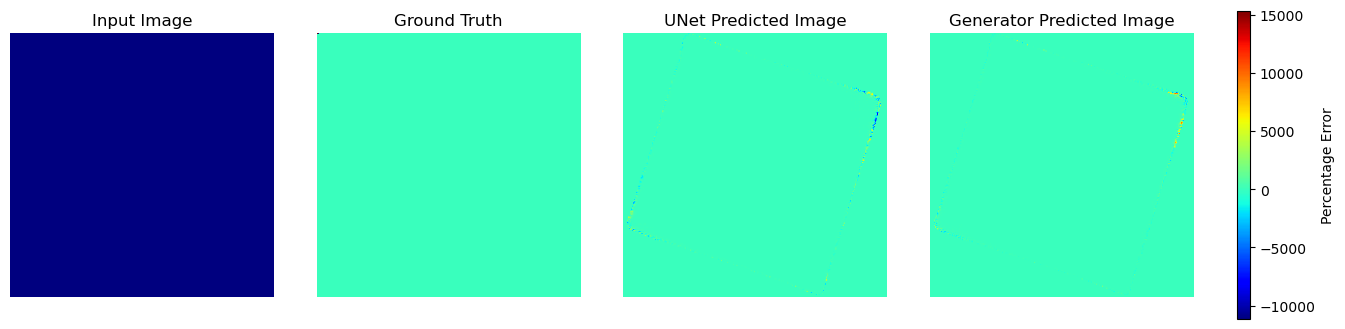

Image index: Run30,sub04
Output pixel intensity of the ground truth (sum of the pixels): 934.1747436523438
Output energy of the ground truth (joules): 31.197539676080446
UNet MSE: 1.1174583050888032e-05, MAPE: 86.8135986328125%, Contrast: 0.01657673344016075
Generator MSE: 2.0650750229833648e-05, MAPE: 71.77238464355469%, Contrast: 0.018238114193081856


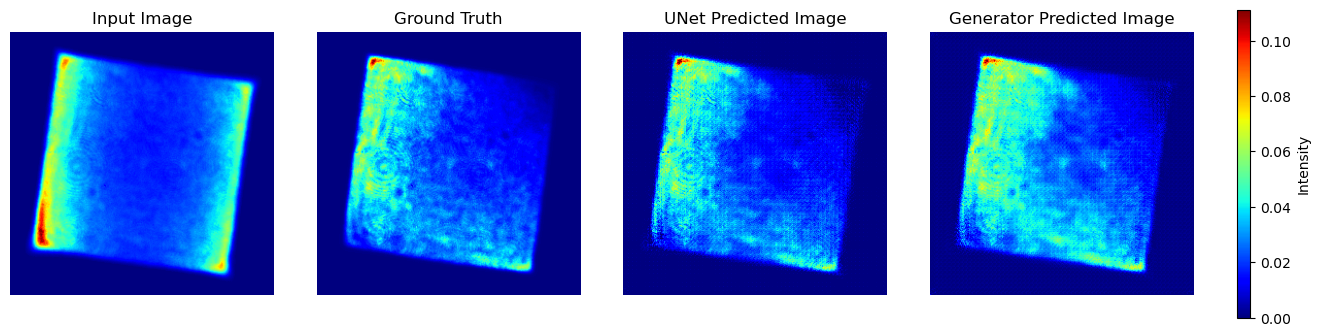

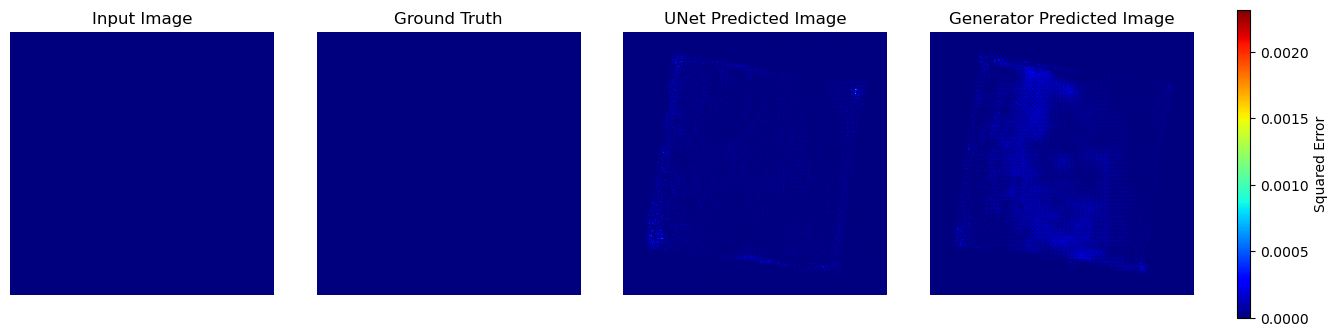

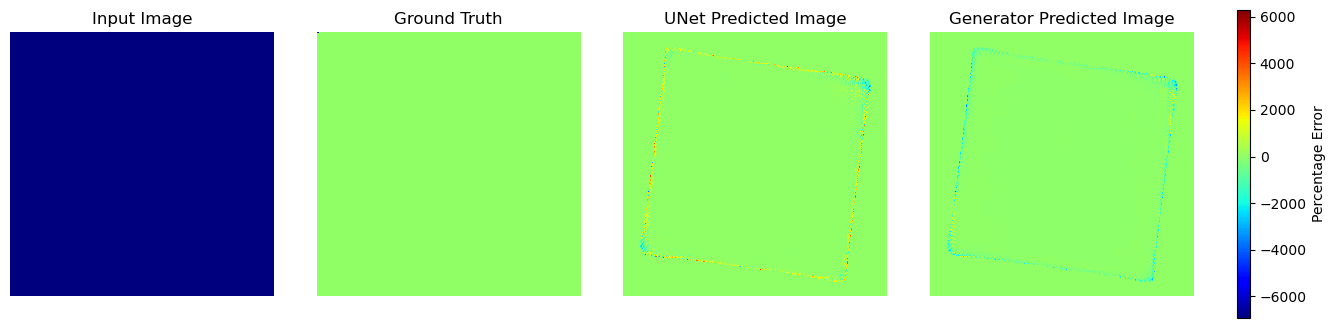

Image index: Run48,sub35
Output pixel intensity of the ground truth (sum of the pixels): 60617.70703125
Output energy of the ground truth (joules): 2024.378557684739
UNet MSE: 0.0014064275892451406, MAPE: 38.56428527832031%, Contrast: 0.9793181419372559
Generator MSE: 0.0009062956087291241, MAPE: 23.145946502685547%, Contrast: 0.9716892242431641


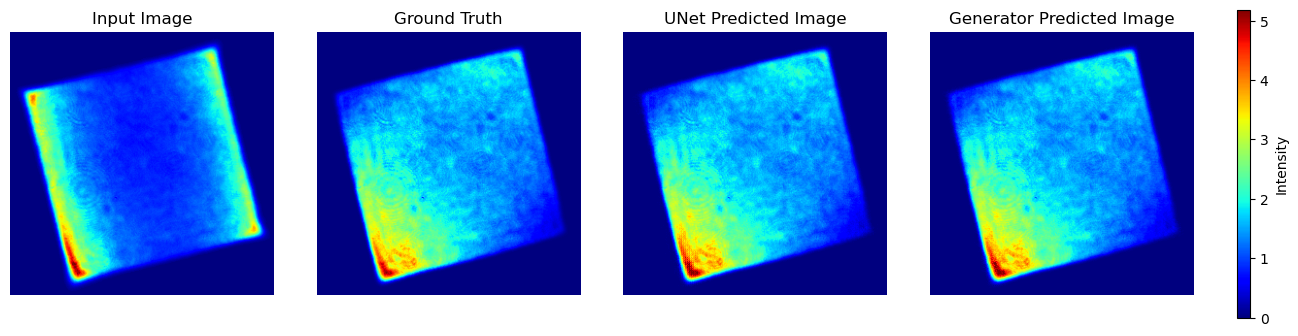

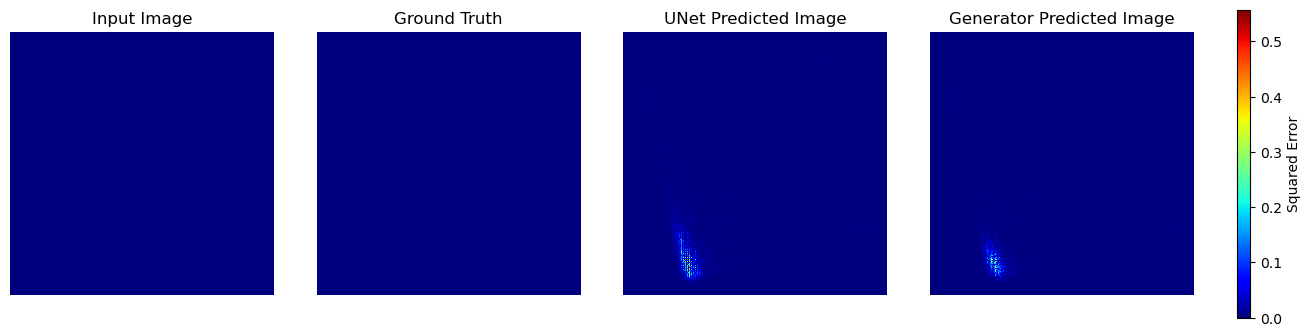

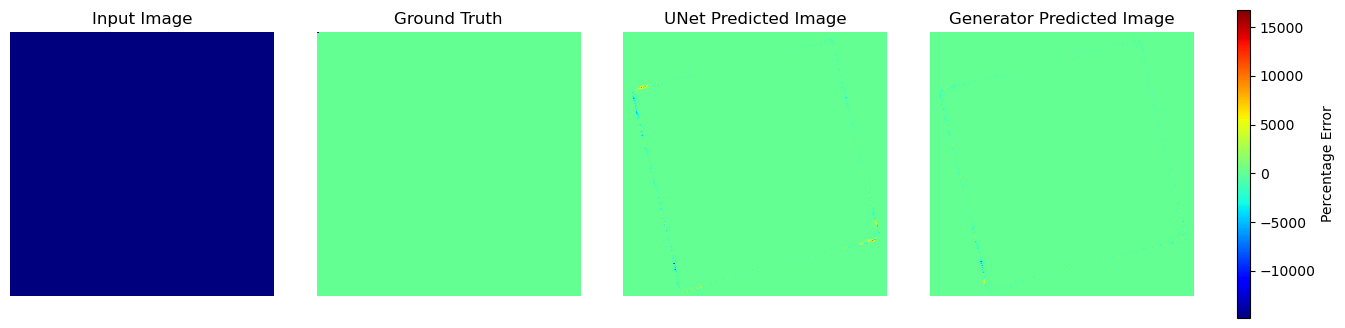

Image index: Run34,sub16
Output pixel intensity of the ground truth (sum of the pixels): 17847.9140625
Output energy of the ground truth (joules): 596.045879942283
UNet MSE: 0.00010017929889727384, MAPE: 31.659866333007812%, Contrast: 0.31635522842407227
Generator MSE: 0.00012267126294318587, MAPE: 25.50815200805664%, Contrast: 0.3157810866832733


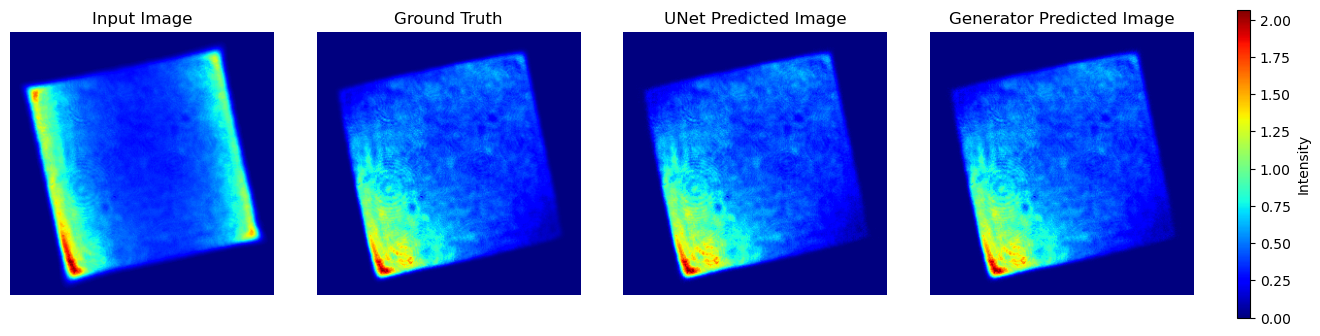

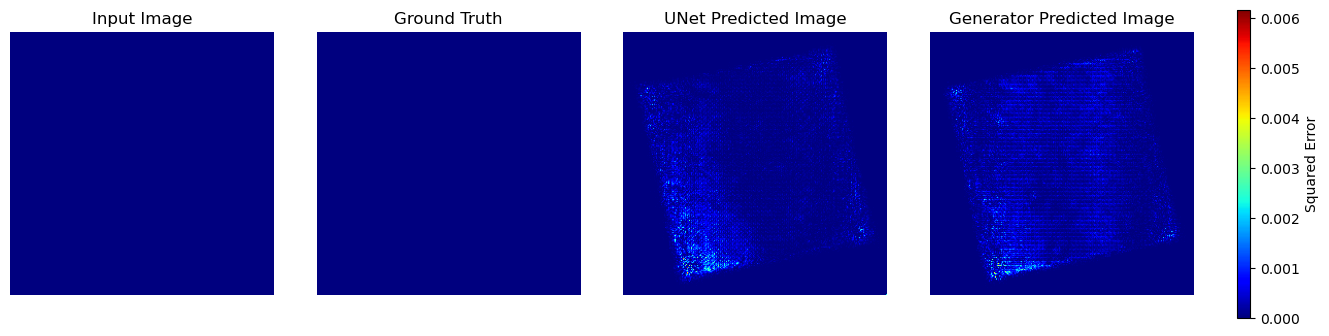

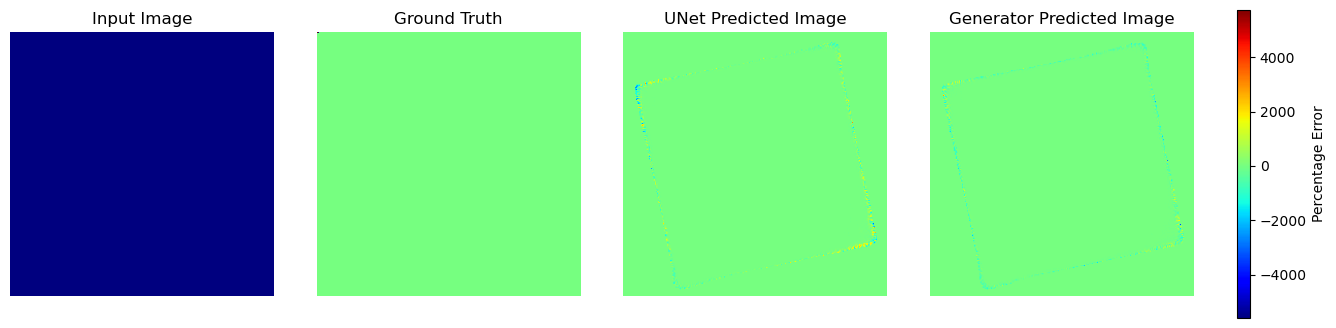

In [ ]:
models = {
    'UNet': unet,
    #'UNet_L2': unet_L2,
    'Generator': generator,
    #'Generator_L2': generator_L2
}

joules_scalar = 0.0333958286584664 # convert energy to joules

for i in range(len(path_selections)):

    input_path, output_path = path_selections[i]
    input_data = load_data_from_one_path(input_path)
    output_data = load_data_from_one_path(output_path)

    test_input_tensor = input_data.unsqueeze(0).unsqueeze(0).to(device)  # Add batch dimension
    tar_tensor = output_data.unsqueeze(0)

    joules_scalar = 0.0333958286584664 # convert energy to joules

    images = [test_input_tensor, tar_tensor]
    titles = ['Input Image', 'Ground Truth']

    print(f'Image index: {selections[i]}')
    print(f'Output pixel intensity of the ground truth (sum of the pixels): {np.sum(tar_tensor.cpu().squeeze().numpy())}')
    print(f'Output energy of the ground truth (joules): {np.sum(tar_tensor.cpu().squeeze().numpy()) * joules_scalar}')

    for model_name, model in models.items():
        with torch.no_grad():
            prediction_tensor = model(test_input_tensor).cpu().squeeze()  # Generate prediction and move to CPU
            mse = mse_loss(prediction_tensor, tar_tensor.cpu().squeeze()).item()
            mape = calculate_mape(tar_tensor.cpu().squeeze(), prediction_tensor)
            
            print(f'{model_name} MSE: {mse}, MAPE: {mape}%, Contrast: {calculate_contrast(prediction_tensor.numpy())}')

            #prediction = prediction_tensor.numpy()
            images.append(prediction_tensor)
            titles.append(f'{model_name} Predicted Image')

    images = [tensor.cpu().squeeze().numpy() for tensor in images]

    generate_images_samescale(images, titles)  # Same color scale for all images (except input)

    # mse_unet = mse_loss(torch.from_numpy(images[2]), torch.from_numpy(images[1])).item()
    # mape_unet = calculate_mape(torch.from_numpy(images[1]), torch.from_numpy(images[2]))
    # mse_generator = mse_loss(torch.from_numpy(images[3]), torch.from_numpy(images[1])).item()
    # mape_generator = calculate_mape(torch.from_numpy(images[1]), torch.from_numpy(images[3]))

    mse_unet_pixel = calculate_mse_pixel(torch.from_numpy(images[1]), torch.from_numpy(images[2]))
    mpe_unet_pixel = calculate_mpe_pixel(torch.from_numpy(images[1]), torch.from_numpy(images[2]))
    mpe_unet_pixel = np.nan_to_num(mpe_unet_pixel, nan=0.0, posinf=0.0, neginf=0.0)
    mse_generator_pixel = calculate_mse_pixel(torch.from_numpy(images[1]), torch.from_numpy(images[3]))
    mpe_generator_pixel = calculate_mpe_pixel(torch.from_numpy(images[1]), torch.from_numpy(images[3]))
    mpe_generator_pixel = np.nan_to_num(mpe_generator_pixel, nan=0.0, posinf=0.0, neginf=0.0)

    input_zeros = torch.zeros(test_input_tensor.squeeze().shape)
    tar_mse = np.zeros(tar_tensor.squeeze().shape)
    tar_mse[0,0] = max(torch.max(mse_unet_pixel), torch.max(mse_generator_pixel))
    tar_mse[0,1] = min(torch.min(mse_unet_pixel), torch.min(mse_generator_pixel))
    tar_mpe = np.zeros(tar_tensor.squeeze().shape)
    tar_mpe[0,0] = max(np.max(mpe_unet_pixel), np.max(mpe_generator_pixel))
    tar_mpe[0,1] = min(np.min(mpe_unet_pixel), np.min(mpe_generator_pixel))

    generate_images_samescale([input_zeros, tar_mse, mse_unet_pixel, mse_generator_pixel], titles, cbar_title='Squared Error')
    generate_images_samescale([input_zeros, tar_mpe, mpe_unet_pixel, mpe_generator_pixel], titles, cbar_title='Percentage Error')

In [ ]:
# def plot_mape_hist(mape_unet, mape_generator, bin_width=100):
#     # Define the number of bins and the range for the histograms
#     # Adjust the bin_width and range based on the MAPE values
#     #bin_width = 1  # Adjust this based on the scale of your MAPE values
#     bins = np.arange(
#         min(np.min(mape_unet), np.min(mape_generator)),
#         max(np.max(mape_unet), np.max(mape_generator)) + bin_width,
#         bin_width
#     )

#     plt.hist(mape_unet, bins=bins, alpha=0.5, label='UNet')
#     plt.hist(mape_generator, bins=bins, alpha=0.5, label='pix2pix Generator')
#     plt.legend(loc='upper right')
#     plt.xlabel('MAPE (%)')
#     plt.ylabel('Frequency')
#     plt.title('Histogram of MAPEs')
#     plt.show()

## correlation between error and input energy

In [ ]:
def get_dataset_size(dataset):
    X, y = dataset
    return X.shape[0]

def get_mse_error(model, dataset):
    X, y = dataset
    X, y = torch.from_numpy(X).unsqueeze(1).to(device).float(), torch.from_numpy(y).unsqueeze(1).to(device).float()
    with torch.no_grad():
        pred = model(X)
        mse = mse_loss(pred, y).item()
    return mse

def get_mape_error(model, dataset):
    X, y = dataset
    X, y = torch.from_numpy(X).unsqueeze(1).to(device).float(), torch.from_numpy(y).unsqueeze(1).to(device).float()
    with torch.no_grad():
        pred = model(X)
        mape = calculate_mape(y, pred)
    return mape

### get errors for individual images

In [ ]:
# '''
# load models
# '''

# unet_models = load_models(model_paths['unet'])
# unet_L2_models = load_models(model_paths['unet_L2'])
# generator_models = load_models(model_paths['generator'])
# generator_L2_models = load_models(model_paths['generator_L2'])

In [102]:
def plot_error_vs_energy(input_dict, output_averages_pic, DATASET_NAME, error_type):
    # Sorting output energies for line plot coherence
    sorted_indices = np.argsort(output_averages_pic)
    sorted_output_averages = output_averages_pic[sorted_indices]
    
    model_type1 = list(input_dict.keys())[0]
    model_type2 = list(input_dict.keys())[1]
    model_errors1 = input_dict[model_type1]
    model_errors2 = input_dict[model_type2]
    
    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot MSEs for all model_type1
    for model_errors in model_errors1:
        sorted_errors = np.array(model_errors)[sorted_indices]
        plt.plot(sorted_output_averages, sorted_errors, color='blue', alpha=0.5, label=model_type1 if model_type1 not in plt.gca().get_legend_handles_labels()[1] else "")

    # Plot MSEs for all model_type2
    for model_errors in model_errors2:
        sorted_errors = np.array(model_errors)[sorted_indices]
        plt.plot(sorted_output_averages, sorted_errors, color='orange', alpha=0.5, label=model_type2 if model_type2 not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel("Ground Truth UV Energy (Joules)")
    plt.ylabel(error_type)
    plt.title(f"{DATASET_NAME} {error_type} vs. Ground Truth UV Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

from scipy.stats import sem

def plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, error_type, limit_x = None, limit_y = None):
    '''
    Plots the mean error vs. energy with 95% confidence intervals.
    '''
    # Sorting output energies for line plot coherence
    sorted_indices = np.argsort(output_averages_pic)
    sorted_output_averages = output_averages_pic[sorted_indices]

    # Plotting
    plt.figure(figsize=(10, 6))

    for model_type, model_errors in input_dict.items():
        model_mean = np.mean(model_errors, axis=0)[sorted_indices]
        model_sem = sem(model_errors, axis=0)[sorted_indices]

        # Calculate and print average SEM for the model type
        avg_sem = np.mean(model_sem)
        print(f"Average SEM for {model_type}: {avg_sem:.10f}")

        # Calculate 95% confidence interval (1.96 * SEM)
        conf_interval = 1.96 * model_sem

        # Plot mean line and 95% confidence interval
        plt.plot(sorted_output_averages, model_mean, label=model_type)
        plt.fill_between(sorted_output_averages, model_mean - conf_interval, model_mean + conf_interval, alpha=0.2)

    plt.xlabel("Ground Truth UV Energy (Joules)")

    # Set x-axis limits here
    if limit_x:
        plt.xlim(limit_x)

    if limit_y:
        plt.ylim(limit_y)

    plt.ylabel(error_type)
    plt.title(f"{DATASET_NAME} {error_type} vs. Ground Truth UV Energy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# DATASET_NAME = "Run 22"
# dataset = datasets_dict[DATASET_NAME]
# output_averages_pic = np.sum(dataset[1], axis=(1, 2)) * joules_scalar

# # Calculate MSEs for all models
# unet_mses_all = calculate_mses_for_models(unet_models, dataset)
# generator_mses_all = calculate_mses_for_models(generator_models, dataset)

In [ ]:
# plot_error_vs_energy(unet_mses_all, generator_mses_all, output_averages_pic, DATASET_NAME, "MSE")

In [ ]:
# unet_mses_all_norm = np.array(unet_mses_all) / np.array(output_averages_pic)
# generator_mses_all_norm = np.array(generator_mses_all) / np.array(output_averages_pic)

# plot_error_vs_energy(unet_mses_all_norm, generator_mses_all_norm, output_averages_pic, DATASET_NAME, "MSE Normalized")

#### MSE

In [ ]:
# # Load all models for a given model type
# def load_models(model_paths):
#     return [load_model_state(path) for path in tqdm(model_paths)]

# Calculate MSE for all models of a given type
def calculate_mses_for_models(model_path_list, dataset):
    mses = []
    for model_path in tqdm(model_path_list):
        model = load_model_state(model_path)
        model_mses = []
        for i in range(dataset[0].shape[0]):
            input_img = np.expand_dims(dataset[0][i], axis=0)
            output_img = np.expand_dims(dataset[1][i], axis=0)
            model_mses.append(get_mse_error(model, (input_img, output_img)))
        mses.append(model_mses)
    return mses

joules_scalar = 0.0333958286584664  # convert energy to joules

In [ ]:
'''
get errors for individual images for each model for the test dataset
'''

# unet_models = load_models(model_paths['unet'])
# generator_models = load_models(model_paths['generator'])

# sums = y_test.sum(dim=[2, 3])
# sums = sums.squeeze()
# output_averages_pic = sums.cpu().numpy()
DATASET_NAME = 'Test Data'
dataset = (X_test.squeeze(1), y_test.squeeze(1))
output_averages_pic = np.sum(dataset[1].cpu().numpy(), axis=(1, 2)) * joules_scalar

# Calculate MSEs for all models
unet_mses_all = calculate_mses_for_models(model_paths['unet'], dataset)
unet_L2_mses_all = calculate_mses_for_models(model_paths['unet_L2'], dataset)
generator_mses_all = calculate_mses_for_models(model_paths['generator'], dataset)
generator_L2_mses_all = calculate_mses_for_models(model_paths['generator_L2'], dataset)

100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Average SEM for UNet_L1: 0.0000968650
Average SEM for pix2pix_Generator_L1: 0.0001146520


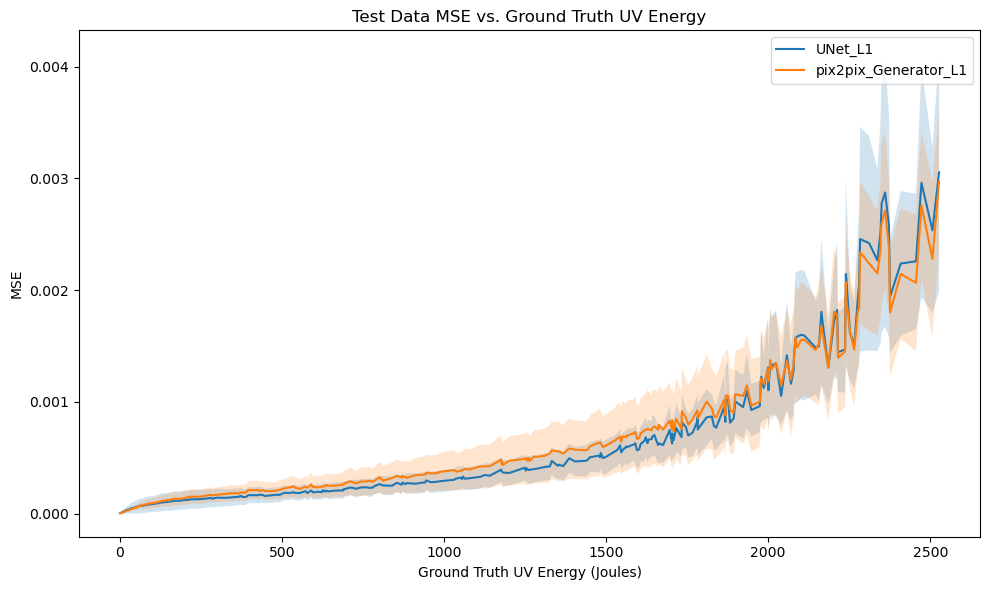

In [ ]:
input_dict = {"UNet_L1": unet_mses_all, "pix2pix_Generator_L1": generator_mses_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE")

Average SEM for UNet_L1: 0.0000001959
Average SEM for pix2pix_Generator_L1: 0.0000001283


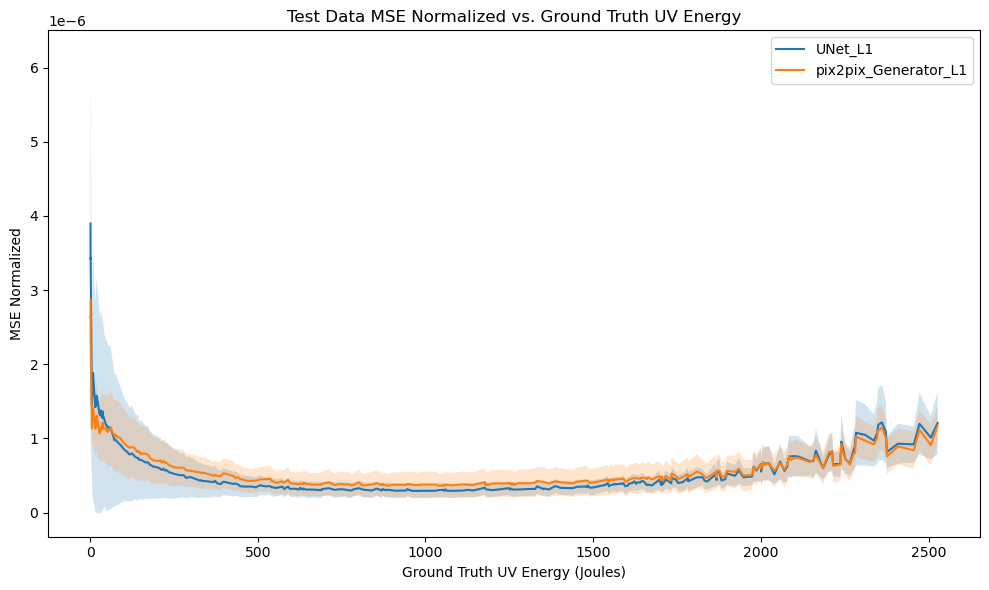

In [ ]:
unet_mses_all_norm = np.array(unet_mses_all) / np.array(output_averages_pic)
generator_mses_all_norm = np.array(generator_mses_all) / np.array(output_averages_pic)

input_dict = {"UNet_L1": unet_mses_all_norm, "pix2pix_Generator_L1": generator_mses_all_norm}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE Normalized")

Average SEM for UNet_L1: 0.0000001959
Average SEM for pix2pix_Generator_L1: 0.0000001283


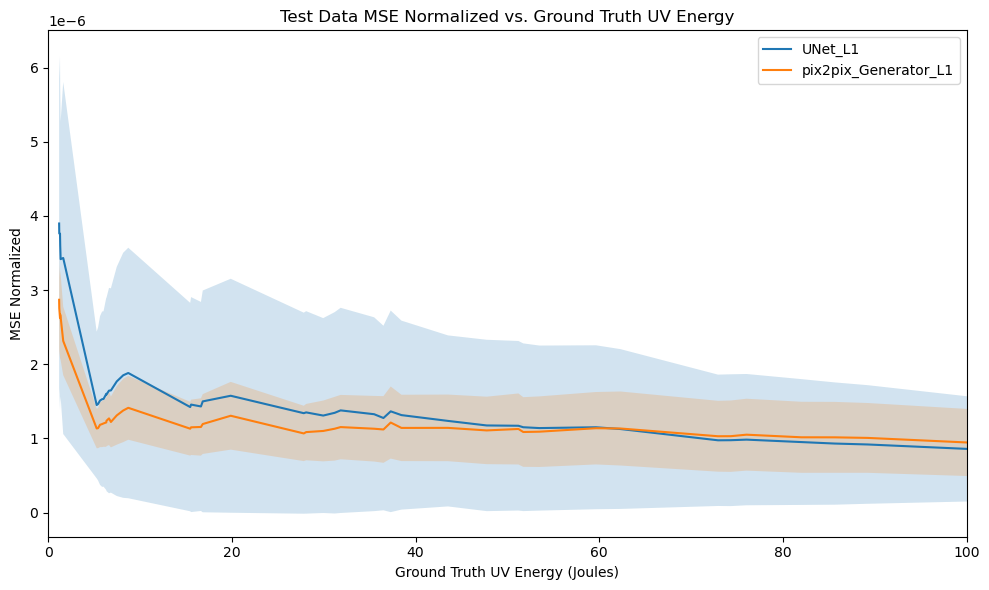

In [ ]:
input_dict = {"UNet_L1": unet_mses_all_norm, "pix2pix_Generator_L1": generator_mses_all_norm}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE Normalized", limit_x=[0,100])

Average SEM for UNet_L1: 0.0000968650
Average SEM for UNet_L2: 0.0000716307


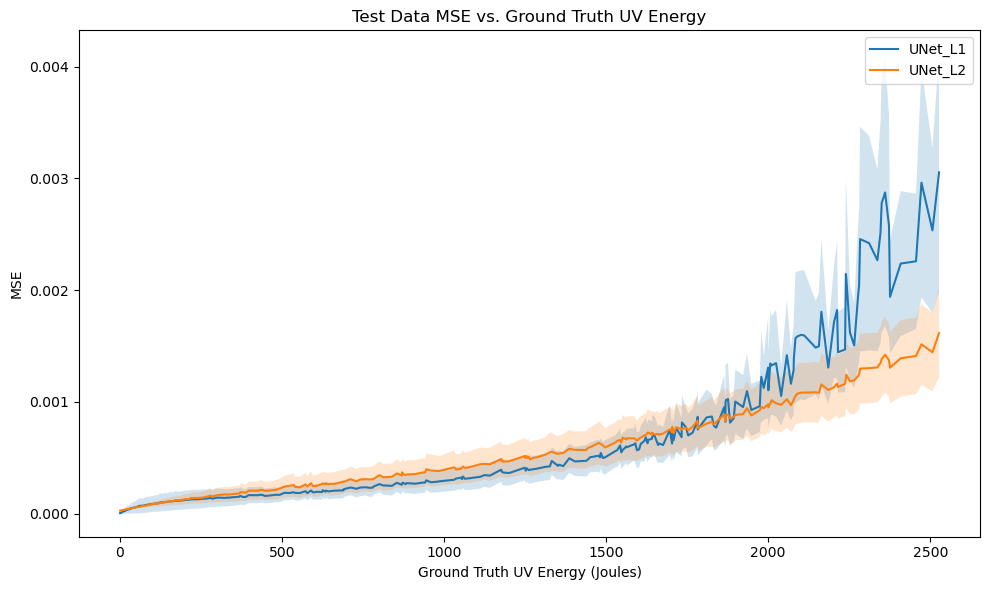

In [ ]:
input_dict = {"UNet_L1": unet_mses_all, "UNet_L2": unet_L2_mses_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE")

#### MSE normalized

Average SEM for UNet_L1: 0.0000001959
Average SEM for UNet_L2: 0.0000001513


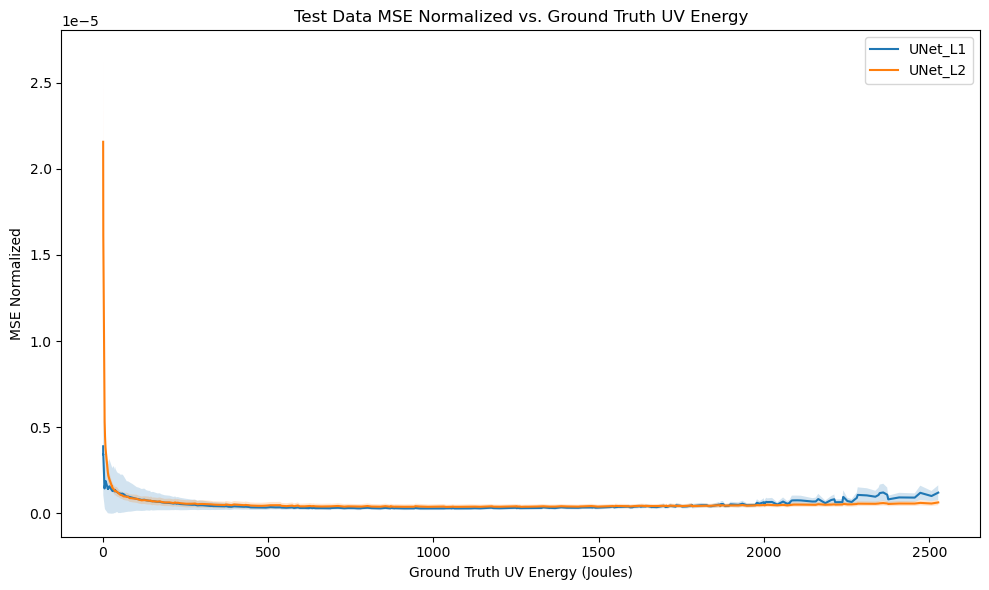

In [ ]:
unet_mses_all_norm = np.array(unet_mses_all) / np.array(output_averages_pic)
unet_L2_mses_all_norm = np.array(unet_L2_mses_all) / np.array(output_averages_pic)

input_dict = {"UNet_L1": unet_mses_all_norm, "UNet_L2": unet_L2_mses_all_norm}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE Normalized")

Average SEM for UNet_L1: 0.0000001959
Average SEM for UNet_L2: 0.0000001513


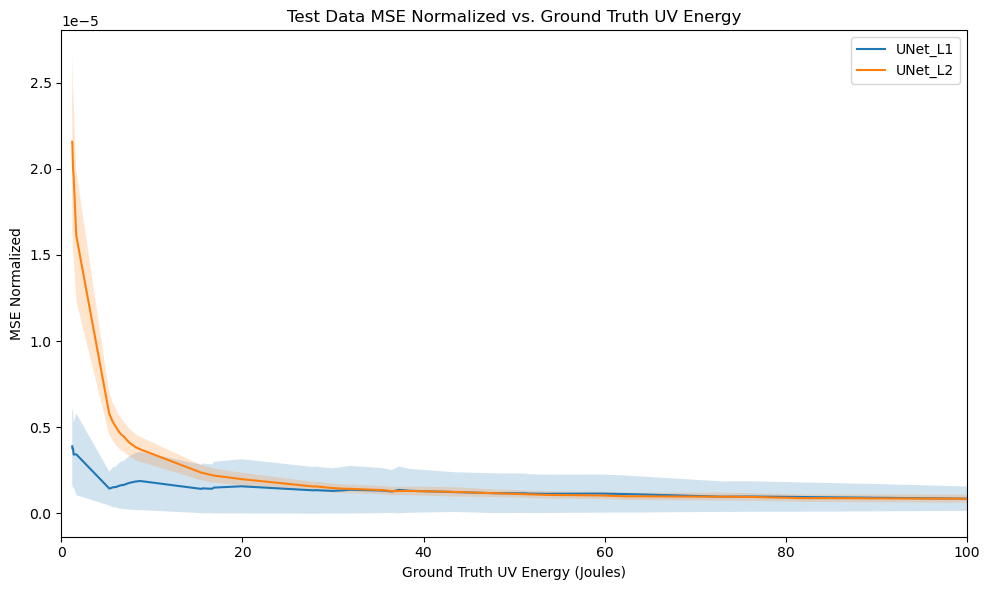

In [ ]:
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE Normalized", limit_x=[0,100])

Average SEM for pix2pix_Generator_L1: 0.0001146520
Average SEM for pix2pix_Generator_L2: 0.0002075331


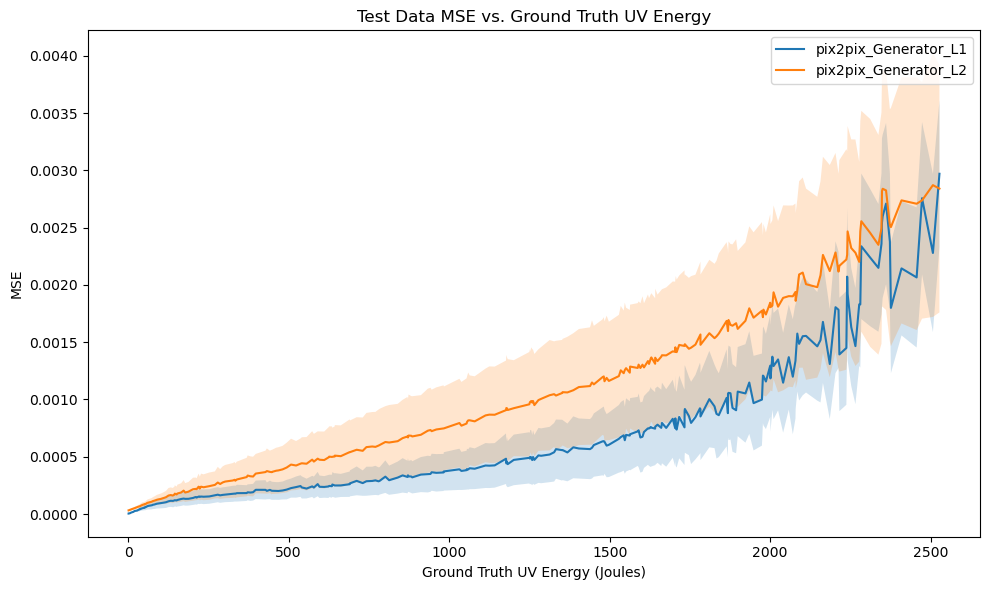

In [ ]:
input_dict = {"pix2pix_Generator_L1": generator_mses_all, "pix2pix_Generator_L2": generator_L2_mses_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE")

Average SEM for pix2pix_Generator_L1: 0.0000001283
Average SEM for pix2pix_Generator_L2: 0.0000002852


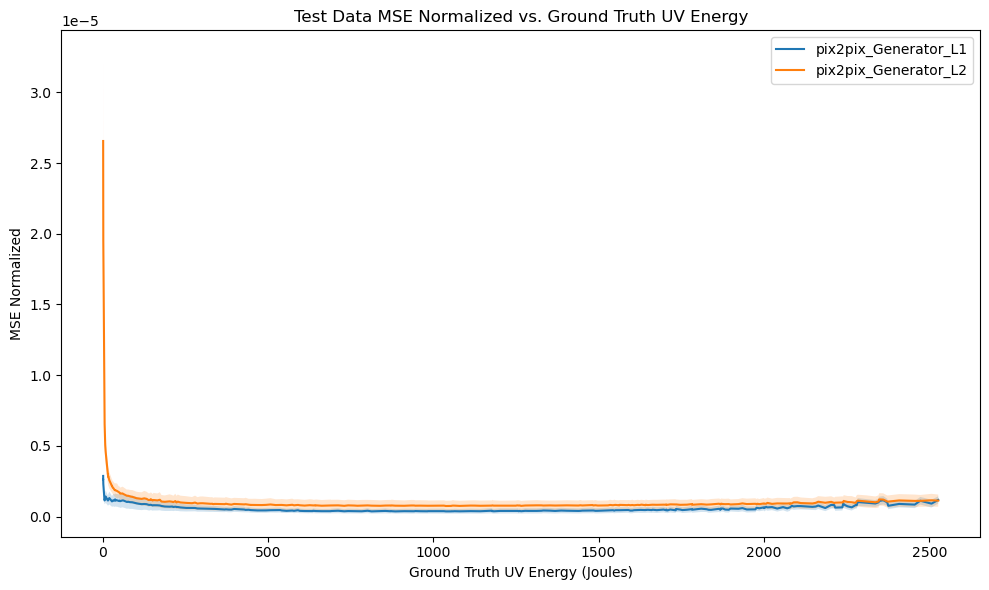

In [ ]:
generator_mses_all_norm = np.array(generator_mses_all) / np.array(output_averages_pic)
generator_L2_mses_all_norm = np.array(generator_L2_mses_all) / np.array(output_averages_pic)

input_dict = {"pix2pix_Generator_L1": generator_mses_all_norm, "pix2pix_Generator_L2": generator_L2_mses_all_norm}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE Normalized")

Average SEM for pix2pix_Generator_L1: 0.0000001283
Average SEM for pix2pix_Generator_L2: 0.0000002852


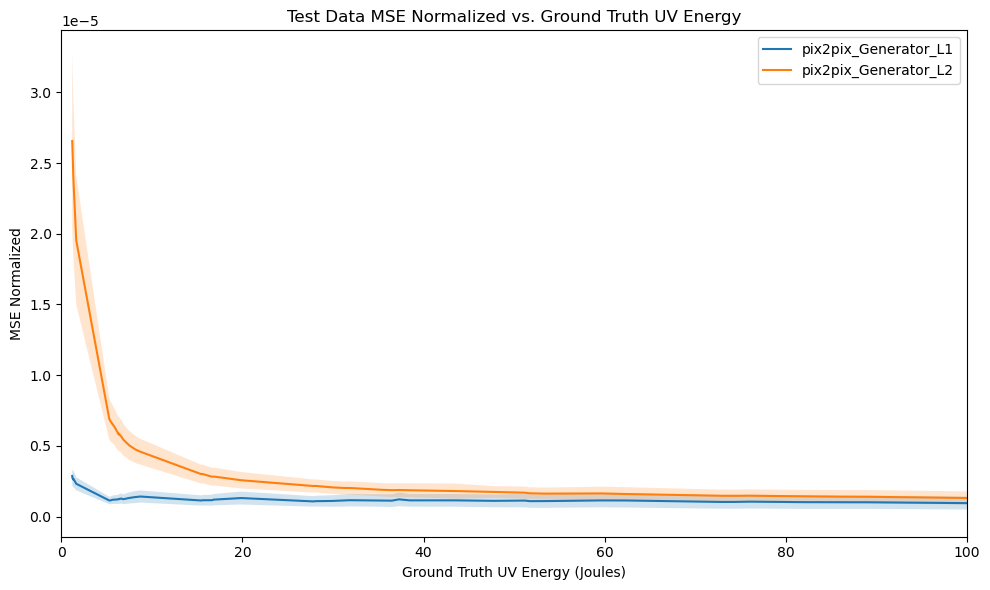

In [ ]:
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MSE Normalized", limit_x=[0,100])

#### MAPE

In [ ]:
# unet_models = load_models(model_paths['unet'])
# generator_models = load_models(model_paths['generator'])

def calculate_mape(y_true, y_pred):
    # Avoid division by zero
    non_zero_mask = y_true != 0
    return torch.mean((torch.abs(y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) * 100).item()
    
# Calculate MAPE for all models of a given type
def calculate_mapes_for_models(model_path_list, dataset):
    mapes = []
    for model_path in tqdm(model_path_list):
        model_mapes = []
        model = load_model_state(model_path)
        for i in range(dataset[0].shape[0]):
            input_img = np.expand_dims(dataset[0][i], axis=0)
            output_img = np.expand_dims(dataset[1][i], axis=0)
            model_mapes.append(get_mape_error(model, (input_img, output_img)))
        mapes.append(model_mapes)
    return mapes

joules_scalar = 0.0333958286584664  # convert energy to joules

# Calculate MSEs for all models
unet_mapes_all = calculate_mapes_for_models(model_paths['unet'], dataset)
unet_L2_mapes_all = calculate_mapes_for_models(model_paths['unet_L2'], dataset)
generator_mapes_all = calculate_mapes_for_models(model_paths['generator'], dataset)
generator_L2_mapes_all = calculate_mapes_for_models(model_paths['generator_L2'], dataset)

100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Average SEM for UNet_L1: 2.9128511891
Average SEM for UNet_L2: 3.5449890206


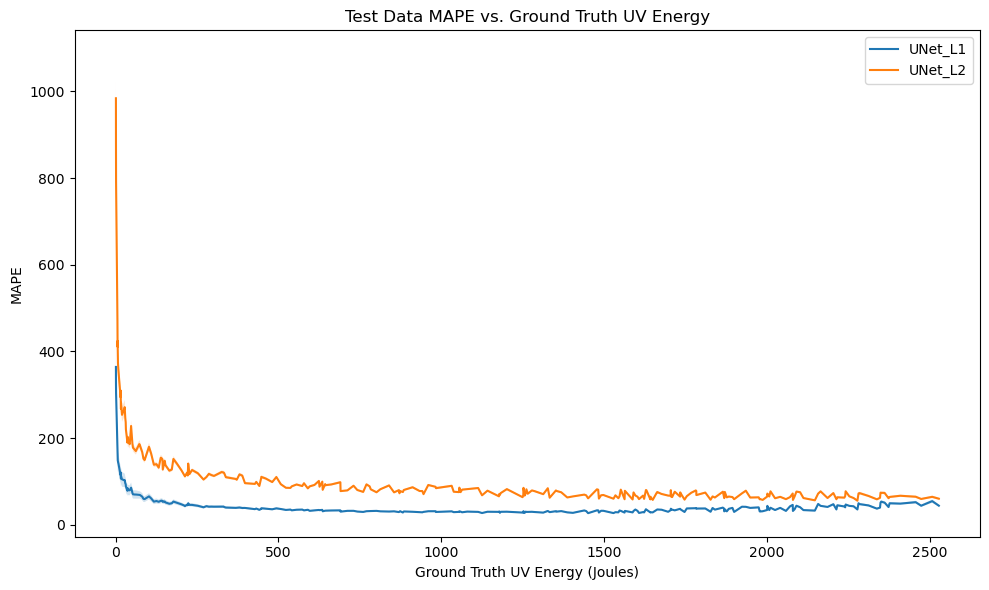

In [ ]:
input_dict = {"UNet_L1": unet_mapes_all, "UNet_L2": unet_L2_mapes_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MAPE")

Average SEM for UNet_L1: 2.9128511891
Average SEM for pix2pix_Generator_L1: 2.1366730689


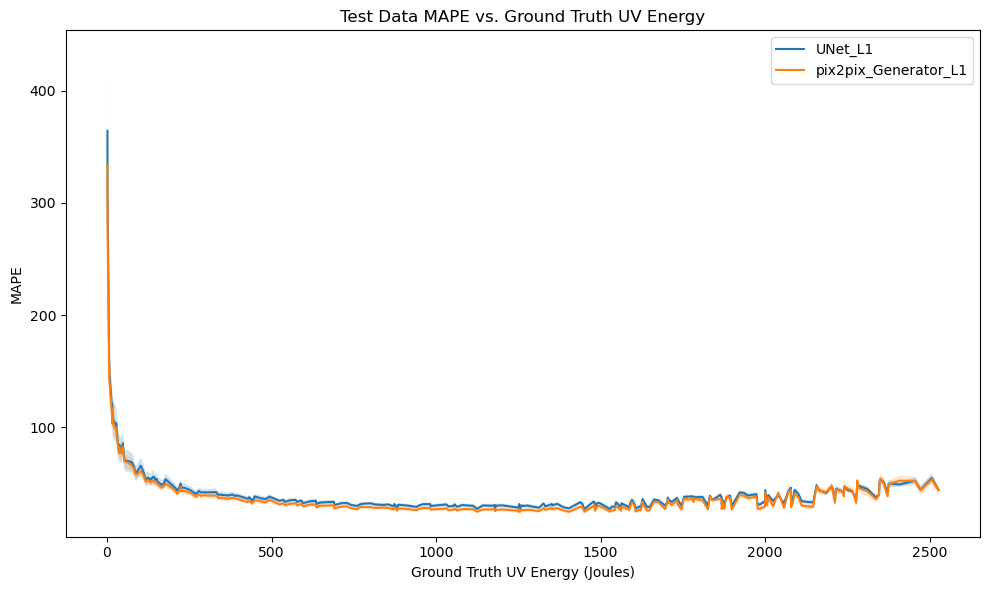

In [ ]:
input_dict = {"UNet_L1": unet_mapes_all, "pix2pix_Generator_L1": generator_mapes_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MAPE")

Average SEM for pix2pix_Generator_L1: 2.1366730689
Average SEM for pix2pix_Generator_L2: 4.2347644049


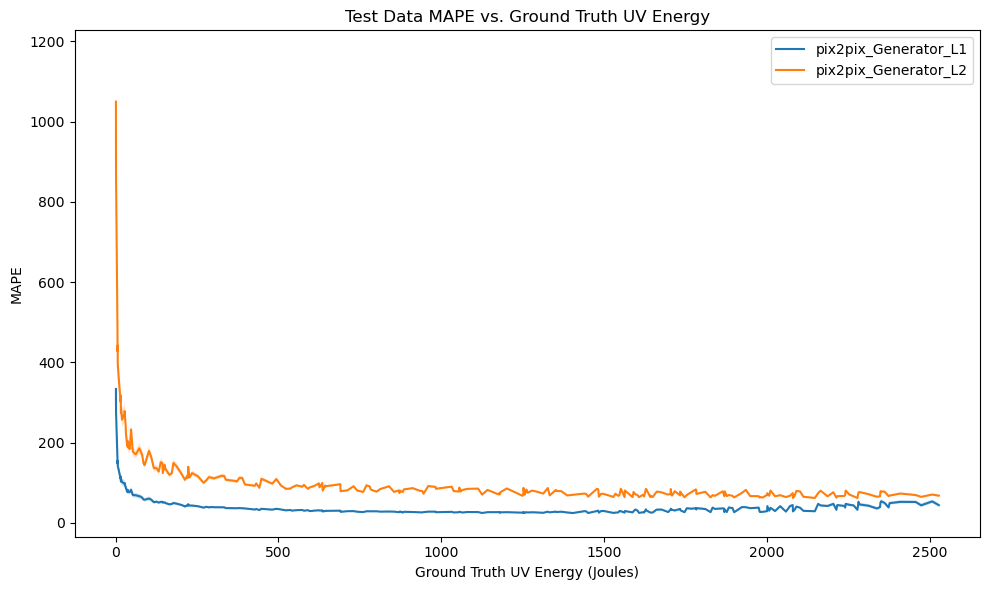

In [ ]:
input_dict = {"pix2pix_Generator_L1": generator_mapes_all, "pix2pix_Generator_L2": generator_L2_mapes_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "MAPE")

#### UV percent error

In [113]:
def calculate_UV_perc_error(y_true, y_pred):
    pred_sum = y_pred.sum()
    ground_truth_sum = y_true.sum()
    return (pred_sum - ground_truth_sum) / ground_truth_sum * 100

def get_UV_error(model, dataset):
    X, y = dataset
    X, y = torch.from_numpy(X).unsqueeze(1).to(device).float(), torch.from_numpy(y).unsqueeze(1).to(device).float()
    with torch.no_grad():
        pred = model(X)
        UV_error = calculate_UV_perc_error(y.cpu(), pred.cpu())
    return UV_error

# Calculate UV perc error for all models of a given type
def calculate_UV_error_for_models(model_path_list, dataset):
    UV_errors = []
    for model_path in tqdm(model_path_list):
        model_UV_errors = []
        model = load_model_state(model_path)
        for i in range(dataset[0].shape[0]):
            input_img = np.expand_dims(dataset[0][i], axis=0)
            output_img = np.expand_dims(dataset[1][i], axis=0)
            model_UV_errors.append(get_UV_error(model, (input_img, output_img)))
        UV_errors.append(model_UV_errors)
    return UV_errors

joules_scalar = 0.0333958286584664  # convert energy to joules

# Calculate MSEs for all models
unet_UV_errors_all = calculate_UV_error_for_models(model_paths['unet'], dataset)
unet_L2_UV_errors_all = calculate_UV_error_for_models(model_paths['unet_L2'], dataset)
generator_UV_errors_all = calculate_UV_error_for_models(model_paths['generator'], dataset)
generator_L2_UV_errors_all = calculate_UV_error_for_models(model_paths['generator_L2'], dataset)

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Average SEM for UNet_L1: 2.4180850983
Average SEM for pix2pix_Generator_L1: 2.1236238480


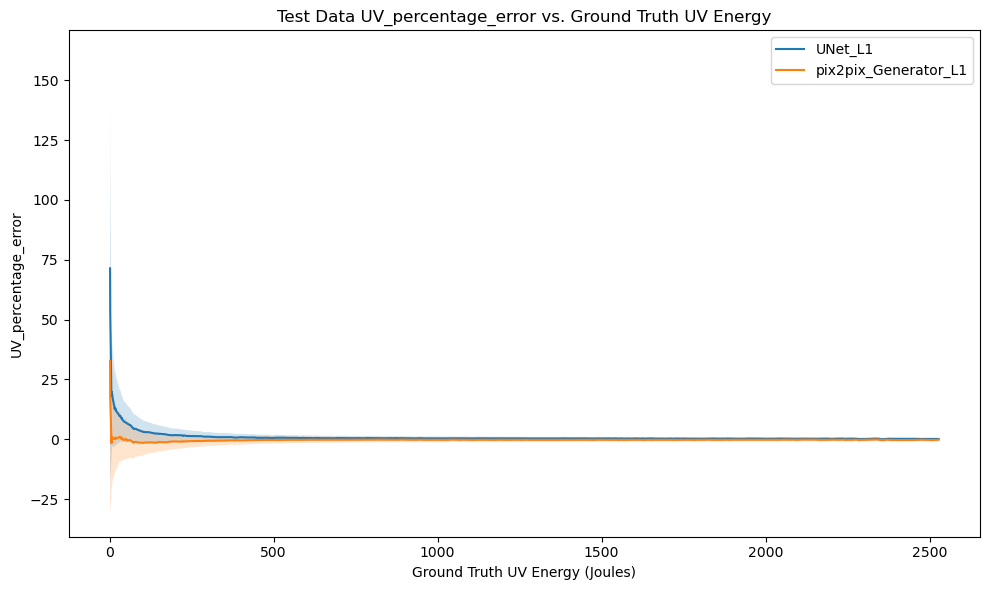

In [124]:
input_dict = {"UNet_L1": unet_UV_errors_all, "pix2pix_Generator_L1": generator_UV_errors_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "UV_percentage_error")

Average SEM for UNet_L1: 2.4180850983
Average SEM for pix2pix_Generator_L1: 2.1236238480


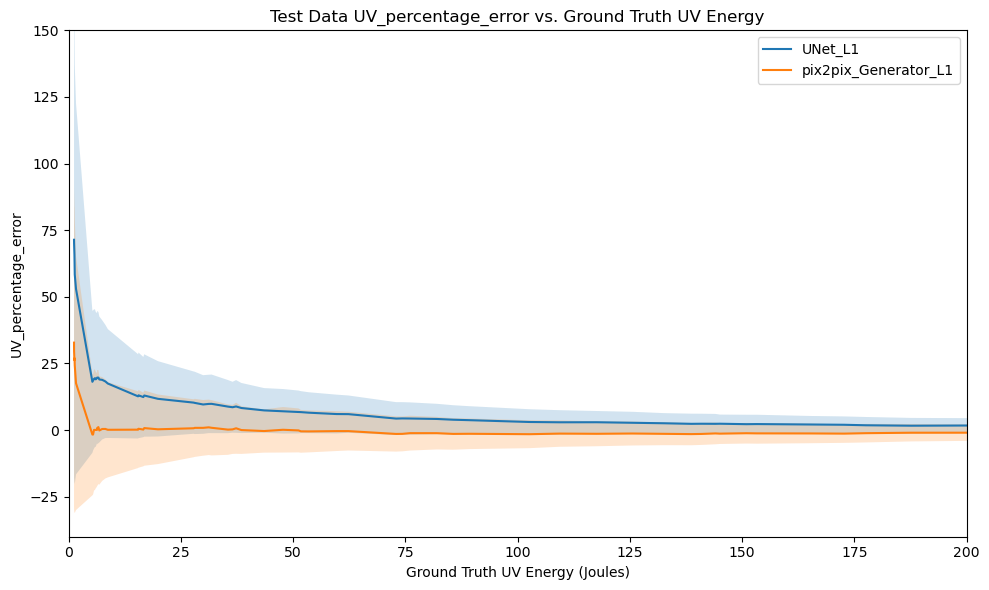

In [127]:
plot_error_vs_energy_ci(input_dict, output_averages_pic, 
DATASET_NAME, "UV_percentage_error", 
limit_x = [0, 200],
limit_y = [-40, 150])

Average SEM for UNet_L1: 2.4180850983
Average SEM for pix2pix_Generator_L1: 2.1236238480


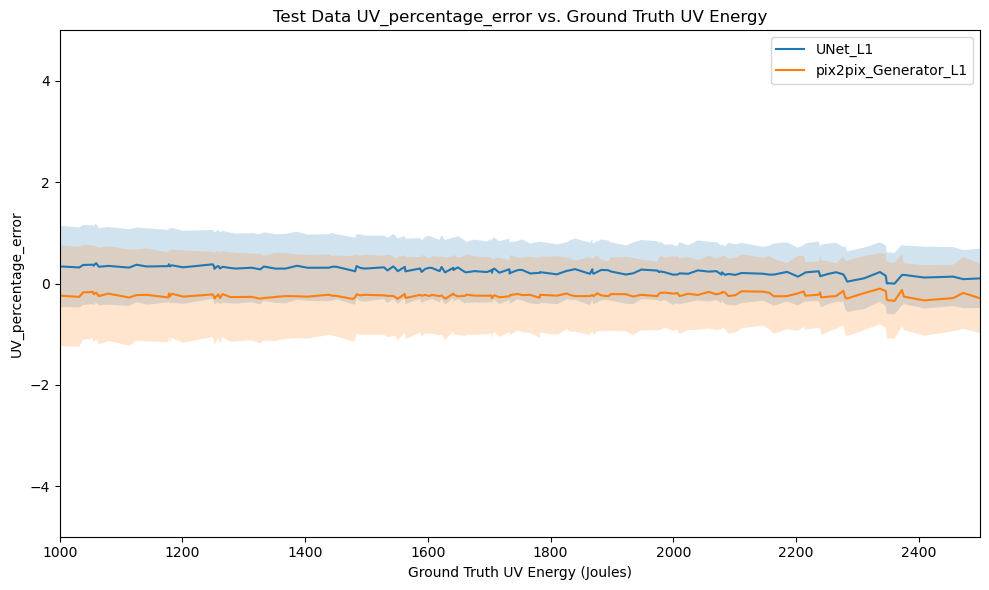

In [128]:
plot_error_vs_energy_ci(input_dict, output_averages_pic, 
DATASET_NAME, "UV_percentage_error", 
limit_x = [1000, 2500],
limit_y = [-5, 5])

Average SEM for UNet_L1: 2.4180850983
Average SEM for UNet_L2: 2.4311194420


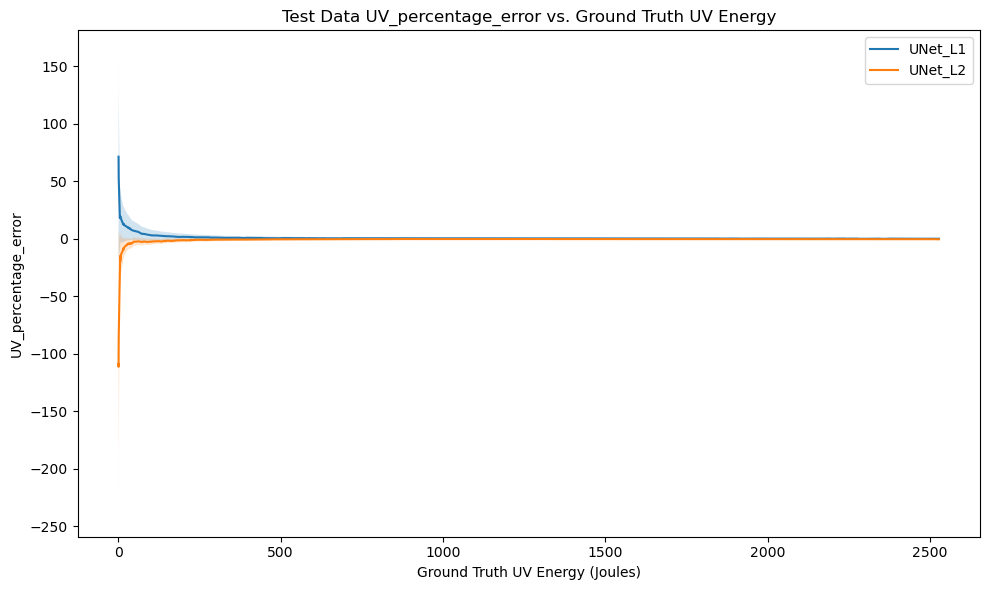

In [117]:
input_dict = {"UNet_L1": unet_UV_errors_all, "UNet_L2": unet_L2_UV_errors_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "UV_percentage_error")

Average SEM for pix2pix_Generator_L1: 2.1236238480
Average SEM for pix2pix_Generator_L2: 4.1566977501


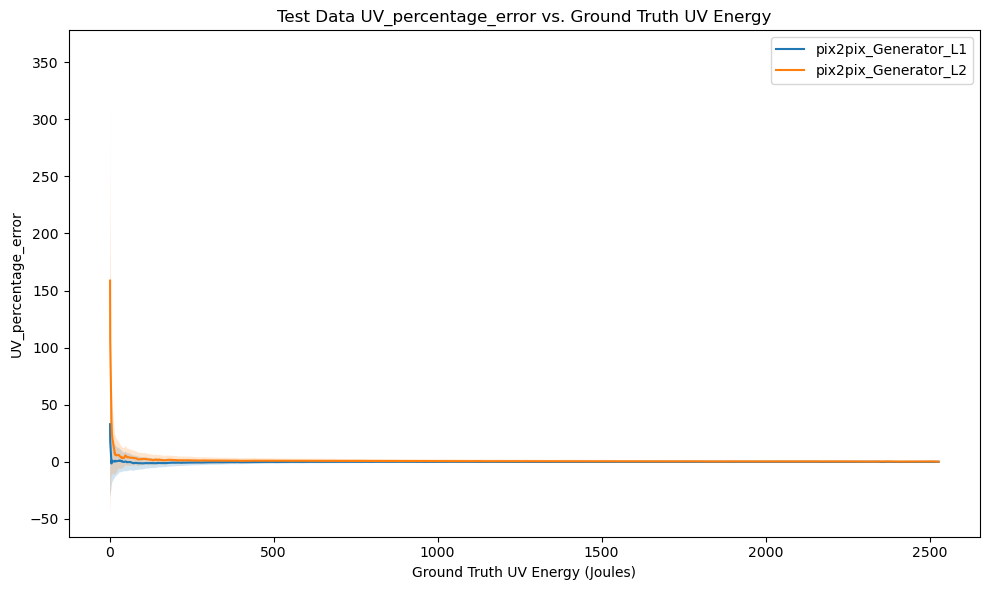

In [118]:
input_dict = {"pix2pix_Generator_L1": generator_UV_errors_all, "pix2pix_Generator_L2": generator_L2_UV_errors_all}
plot_error_vs_energy_ci(input_dict, output_averages_pic, DATASET_NAME, "UV_percentage_error")

In [ ]:
#save to csv

# within_run_errors_dict = {'Output Energy': output_averages_pic,
#                             'UNet MSE': unet_mses_run,
#                             'Generator MSE': generator_mses_run,
#                             'UNet MSE (Normalized)': unet_mses_norm_run,
#                             'Generator MSE (Normalized)': generator_mses_norm_run,
#                             'UNet MAPE': unet_mapes_run,
#                             'Generator MAPE': generator_mapes_run}

# # Create DataFrame
# within_run_errors_df = pd.DataFrame(within_run_errors_dict)
# within_run_errors_df.to_csv('figure3_error_correlation.csv', index=False)
# within_run_errors_df.head()

# compare prediction time UNet vs pix2pix Generator

In [ ]:
import time

In [ ]:
unet = load_model_state(model_paths['unet'][0])
generator = load_model_state(model_paths['generator'][0])

In [ ]:
# Lists to store inference times
times_unet = []
times_generator = []

# Iterate through the test data one datapoint at a time
for i in tqdm(range(len(X_test))):
    # Get the i-th test datapoint and add a batch dimension of 1
    x_single = X_test[i].unsqueeze(0).to(device)

    # Time inference for unet
    start_time = time.time()
    with torch.no_grad():
        _ = unet(x_single)
    end_time = time.time()
    times_unet.append(end_time - start_time)

    # Time inference for generator
    start_time = time.time()
    with torch.no_grad():
        _ = generator(x_single)
    end_time = time.time()
    times_generator.append(end_time - start_time)

# Convert lists to arrays for statistical testing
times_unet_array = np.array(times_unet)
times_generator_array = np.array(times_generator)

# Perform t-test on inference times
t_stat, p_val = ttest_ind(times_unet_array, times_generator_array)

print(f'Mean inference time for unet: {np.mean(times_unet):.4f} seconds, or {1/np.mean(times_unet):.4f} Hz.')
print(f'Mean inference time for generator: {np.mean(times_generator):.4f} seconds, or {1/np.mean(times_generator):.4f} Hz.')

print(f'T-statistic: {t_stat}, P-value: {p_val}')

# Decide whether the difference is statistically significant
alpha = 0.05  # Or another significance level you choose
if p_val < alpha:
    print("The difference in inference times is statistically significant.")
else:
    print("The difference in inference times is not statistically significant.")